In [704]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import re
import string
import nltk
import seaborn as sns
import keras
import collections
from datetime import datetime
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from IPython.core.display import clear_output
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from keras import callbacks
from IPython.core.display import clear_output
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.tag import pos_tag_sents
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [7]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [9]:
articles = pd.read_csv( "full_article2.txt", index_col=None, header=None, engine='python')
articles.columns = ['Symbol', 'Article', 'Month-Day', 'Year']
articles['Year'] = articles['Year'].astype(str)
articles['Date'] = articles['Month-Day'] + " " + articles['Year']
articles['Date'] = articles['Date'].str.strip()
articles['Date'] = articles['Date'].str.slice(start = 2, stop = 13)
articles['Date'] = articles['Date'].str.strip()
articles = articles[['Symbol', 'Article', 'Date']]
articles

,Symbol,Article,Date
0,MO,The other big story Monday was oil storming h...,Mar 22 2022
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,Mar 22 2022
2,MO,The members of this alcohol and tobacco indus...,Mar 17 2022
3,MO,(Reuters) - An administrative law judge dismi...,Feb 24 2022
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,Feb 15 2022
...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,Jun 25 2015
62475,ZTS,Investing.com – U.S. stocks were lower after ...,Jun 25 2015
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,Apr 27 2015
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,Mar 09 2015


In [10]:
articles.at[articles[articles['Date'].str.contains('hours') == True].index, 'Date'] = 'Apr 06 2022'
articles = articles[articles['Date'].str.len() == 11]
articles = articles[articles['Date'].str.contains("minutes") == False]
articles['Date'] = pd.to_datetime(articles['Date'], format = '%b %d %Y')
articles

,Symbol,Article,Date
0,MO,The other big story Monday was oil storming h...,2022-03-22
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22
2,MO,The members of this alcohol and tobacco indus...,2022-03-17
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15
...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09


In [11]:
df = articles.copy()
df

,Symbol,Article,Date
0,MO,The other big story Monday was oil storming h...,2022-03-22
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22
2,MO,The members of this alcohol and tobacco indus...,2022-03-17
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15
...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09


In [19]:
bert_df = pd.read_csv('bert_df.csv')
bert_df.rename(columns = {'Unnamed: 0': 'idx'}, inplace = True)
bert_df = bert_df.set_index('idx')
bert_df

,Symbol,Date,dateSold,currentPrice,nextMonthPrice
idx,,,,,
2,MO,2022-03-17,2022-04-16,50.815872,54.110001
3,MO,2022-02-24,2022-03-26,48.731728,53.619999
4,MO,2022-02-15,2022-03-17,49.469044,50.815872
5,MO,2022-01-27,2022-02-26,49.488705,50.609425
6,MO,2022-01-27,2022-02-26,49.488705,50.609425
...,...,...,...,...,...
62474,ZTS,2015-06-25,2015-07-25,52.983288,47.348190
62475,ZTS,2015-06-25,2015-07-25,52.983288,47.348190
62476,ZTS,2015-04-27,2015-05-27,44.803303,47.309917


In [21]:
df = pd.merge(df, bert_df[['dateSold', 'currentPrice', 'nextMonthPrice']], left_index = True, right_index = True)
df

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,2022-04-16,50.815872,54.110001
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,2022-03-26,48.731728,53.619999
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,2022-02-26,49.488705,50.609425
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425
...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,2015-07-25,52.983288,47.348190
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,2015-07-25,52.983288,47.348190
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,2015-05-27,44.803303,47.309917
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,2015-04-08,44.207355,44.210152


In [12]:
daily_prices = pd.read_csv('daily_prices.csv')
daily_prices

,Date,Open,High,Low,Close,Volume,Symbol
0,2014-04-09,107.283329,107.974706,106.885983,107.950867,2671900.0,MMM
1,2014-04-10,107.863458,108.419740,106.409171,106.464806,2857200.0,MMM
2,2014-04-11,105.988008,106.361514,105.209213,105.209213,2368200.0,MMM
3,2014-04-14,106.051558,106.107193,104.915156,105.813148,2058100.0,MMM
4,2014-04-15,105.908540,106.766808,104.915176,106.560181,2119000.0,MMM
...,...,...,...,...,...,...,...
1000210,2022-04-04,191.139999,191.979996,187.179993,188.740005,2603600.0,ZTS
1000211,2022-04-05,188.740005,190.740005,187.690002,188.399994,2059300.0,ZTS
1000212,2022-04-06,188.160004,192.330002,186.520004,191.380005,2843500.0,ZTS
1000213,2022-04-07,191.199997,199.339996,190.970001,197.929993,2781400.0,ZTS


In [10]:
current_price = []
for i in range(len(df)):
    if i % 500 == 0:
        print(i)
    if i % 2000 == 0:
        clear_output(wait = True)
    subset = daily_prices[(daily_prices['Date'] <= str(df.iloc[i]['Date'])[0: 10]) & (df.iloc[i]['Symbol'] == daily_prices['Symbol'])]
    if len(subset) == 0:
        current_price.append(np.nan)
        continue
    subset = subset[subset['Date'] == max(subset['Date'])]
    current_price.append(subset.iloc[0]['Close'])
current_price[0]

52.40848159790039

In [12]:
def get_current_price(date, sym):
    subset = daily_prices[(daily_prices['Date'] <= str(date)[0: 10]) & (sym == daily_prices['Symbol'])]
    if len(subset) == 0:
        return np.nan
    subset = subset[subset['Date'] == max(subset['Date'])]
    return subset.iloc[0]['Close']

In [ ]:
# 30 days from current date
next_price2 = []
for i in range(len(df)):
    if i % 500 == 0:
        print(i)
    if i % 2000 == 0:
        clear_output(wait = True)
    next_date = df.iloc[i]['Date'] + pd.DateOffset(days = 30)
    next_date = str(next_date)[0:10]
    subset = daily_prices[(daily_prices['Date'] <= next_date) & (df.iloc[i]['Symbol'] == daily_prices['Symbol'])]
    if len(subset) == 0:
        next_price2.append(np.nan)
        continue
    subset = subset[subset['Date'] == max(subset['Date'])]
    if subset.iloc[0]['Date'] <= str(df.iloc[i]['Date'] + pd.DateOffset(days = 20))[0:10]:
        next_price2.append(np.nan)
        continue
    next_price2.append(subset.iloc[0]['Close'])
next_price2[0]

38500
39000
39500
40000


In [10]:
df['currentPrice'] = current_price
df['nextMonthPrice'] = next_price2
df['dateSold'] = df['Date'] + pd.DateOffset(days = 30)
df

,Symbol,Article,Date,currentPrice,nextMonthPrice,dateSold
0,MO,The other big story Monday was oil storming h...,2022-03-22,52.408482,NaN,2022-04-21
1,MO,By Peter NurseInvesting.com -- Stocks in focu...,2022-03-22,52.408482,NaN,2022-04-21
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,50.815872,54.110001,2022-04-16
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,48.731728,53.619999,2022-03-26
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,49.469044,50.815872,2022-03-17
...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,52.983288,47.348190,2015-07-25
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,52.983288,47.348190,2015-07-25
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,44.803303,47.309917,2015-05-27
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,44.207355,44.210152,2015-04-08


In [11]:
df = df.dropna()
#df = df[df['Date'] <= '2022-03-01']
df

,Symbol,Article,Date,currentPrice,nextMonthPrice,dateSold
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,50.815872,54.110001,2022-04-16
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,48.731728,53.619999,2022-03-26
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,49.469044,50.815872,2022-03-17
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,49.488705,50.609425,2022-02-26
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,49.488705,50.609425,2022-02-26
...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,52.983288,47.348190,2015-07-25
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,52.983288,47.348190,2015-07-25
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,44.803303,47.309917,2015-05-27
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,44.207355,44.210152,2015-04-08


In [35]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    sentence = []
    for word, tag in tokens:
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v' 
        else:
            pos = 'a'
        sentence.append(lemmatizer.lemmatize(word, pos))
    return sentence

[nltk_data] Downloading package punkt to //home/rtshinta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     //home/rtshinta/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     //home/rtshinta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     //home/rtshinta/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
df['title/no_stopwords'] = df.apply(lambda row: pos_tag(word_tokenize(row['Article'])), axis = 1)
print("Done 1")
df['title/no_stopwords'] = df.apply(lambda row: lemmatize_sentence(row['title/no_stopwords']), axis = 1)
df

Done 1


,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,2022-04-16,50.815872,54.110001,"[The, member, of, this, alcohol, and, tobacco,..."
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,2022-03-26,48.731728,53.619999,"[(, Reuters, ), -, An, administrative, law, ju..."
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872,"[WASHINGTON, (, Reuters, ), -A, judge, at, the..."
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,2022-02-26,49.488705,50.609425,"[Investing.com, -, Altria, (, NYSE, :, MO, ), ..."
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425,"[By, Geoffrey, Smith, Investing.com, --, Globa..."
...,...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,2015-07-25,52.983288,47.348190,"[(, Reuters, ), -, Canada-based, drugmaker, Va..."
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,2015-07-25,52.983288,47.348190,"[Investing.com, –, U.S., stock, be, low, after..."
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,2015-05-27,44.803303,47.309917,"[By, David, RandallNEW, YORK, (, Reuters, ), -..."
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,2015-04-08,44.207355,44.210152,"[By, Svea, Herbst-BaylissBOSTON, (, Reuters, )..."


In [36]:
def remove_noise(reviews, stop_words = ()):

    cleaned_tokens = []

    for token in reviews:
        token = token.strip()
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = token.replace('--', '')
        token = token.replace('-', '')
        token = token.replace('–', '')
        token = token.replace('investing.com', '')
        token = token.replace('``', '')
        token = token.replace("'s", '')
        token = token.replace('..', '')
        token = token.replace('...', '')
        token = token.replace("'", '')
        token = token.replace("’",'')
        token = token.replace("reuters", "")
        token = token.replace("say", "")
        token = token.replace("company", "")
        token = token.replace("inc", "")
        token = token.replace('p', '')
        token = token.replace('apos', '')
        token = token.replace('aposs', '')
        token = token.replace('er', '')
        token = token.replace('erformer', '')
        token = token.replace('eole', '')
        token = token.replace('ale', '')
        token = token.replace('oint', '')
        token = token.replace('reort', '')
        token = token.replace('aoss', '')
        token = token.replace('also', '')

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [37]:
stop_words = list(stopwords.words('english'))
df['title/no_stopwords'] = df.apply(lambda row: remove_noise(row['title/no_stopwords'], stop_words), axis = 1)
df

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,2022-04-16,50.815872,54.110001,"[memb, alcohol, tobacco, industrybacked, marij..."
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,2022-03-26,48.731728,53.619999,"[reuts, administrative, law, judge, dismiss, f..."
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872,"[washington, reuts, judge, u.s., fedal, trade,..."
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,2022-02-26,49.488705,50.609425,"[investing.com, altria, nyse, mo, thursday, fo..."
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425,"[geoffrey, smith, investing.com, global, marke..."
...,...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,2015-07-25,52.983288,47.348190,"[reuts, canadabased, drugmak, vant, pharmaceut..."
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,2015-07-25,52.983288,47.348190,"[investing.com, u.s., stock, low, aft, close, ..."
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,2015-05-27,44.803303,47.309917,"[david, randallnew, york, reuts, nasdaq, comos..."
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,2015-04-08,44.207355,44.210152,"[svea, hbstbaylissboston, reuts, billionaire, ..."


In [38]:
df['title/clean'] = df.apply(lambda row: ' '.join(row['title/no_stopwords']), axis = 1)
df

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,2022-04-16,50.815872,54.110001,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,2022-03-26,48.731728,53.619999,"[reuts, administrative, law, judge, dismiss, f...",reuts administrative law judge dismiss fedal t...
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872,"[washington, reuts, judge, u.s., fedal, trade,...",washington reuts judge u.s. fedal trade commis...
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,2022-02-26,49.488705,50.609425,"[investing.com, altria, nyse, mo, thursday, fo...",investing.com altria nyse mo thursday fourth q...
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425,"[geoffrey, smith, investing.com, global, marke...",geoffrey smith investing.com global market ste...
...,...,...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,2015-07-25,52.983288,47.348190,"[reuts, canadabased, drugmak, vant, pharmaceut...",reuts canadabased drugmak vant pharmaceuticals...
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,2015-07-25,52.983288,47.348190,"[investing.com, u.s., stock, low, aft, close, ...",investing.com u.s. stock low aft close thursda...
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,2015-05-27,44.803303,47.309917,"[david, randallnew, york, reuts, nasdaq, comos...",david randallnew york reuts nasdaq comosite la...
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,2015-04-08,44.207355,44.210152,"[svea, hbstbaylissboston, reuts, billionaire, ...",svea hbstbaylissboston reuts billionaire inves...


In [96]:
def light_clean(x):
    x = x.lower() # lowercase everything
    x = x.encode('ascii', 'ignore').decode()  # remove unicode characters
    x = re.sub(r'https*\S+', ' ', x) # remove links
    x = re.sub(r'http*\S+', ' ', x)
    # cleaning up text
    x = re.sub(r'\'\w+', '', x) 
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    # remove single letters and numbers surrounded by space
    x = re.sub(r'\s[a-z]\s|\s[0-9]\s', ' ', x)
    return x

In [97]:
df['light_clean'] = df['Article'].apply(light_clean)
df

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,2022-04-16,50.815872,54.110001,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...,the members of this alcohol and tobacco indus...
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,2022-03-26,48.731728,53.619999,"[reuts, administrative, law, judge, dismiss, f...",reuts administrative law judge dismiss fedal t...,(reuters)an administrative law judge dismisse...
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872,"[washington, reuts, judge, u.s., fedal, trade,...",washington reuts judge u.s. fedal trade commis...,washington (reuters) -a judge at the u.s. fed...
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,2022-02-26,49.488705,50.609425,"[investing.com, altria, nyse, mo, thursday, fo...",investing.com altria nyse mo thursday fourth q...,investing.comaltria (nyse:mo) reported on thu...
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425,"[geoffrey, smith, investing.com, global, marke...",geoffrey smith investing.com global market ste...,by geoffrey smithinvesting.com -- global mark...
...,...,...,...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,2015-07-25,52.983288,47.348190,"[reuts, canadabased, drugmak, vant, pharmaceut...",reuts canadabased drugmak vant pharmaceuticals...,(reuters)canada-based drugmaker valeant pharm...
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,2015-07-25,52.983288,47.348190,"[investing.com, u.s., stock, low, aft, close, ...",investing.com u.s. stock low aft close thursda...,investing.com u.s. stocks were lower after th...
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,2015-05-27,44.803303,47.309917,"[david, randallnew, york, reuts, nasdaq, comos...",david randallnew york reuts nasdaq comosite la...,by david randallnew york (reuters)when the na...
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,2015-04-08,44.207355,44.210152,"[svea, hbstbaylissboston, reuts, billionaire, ...",svea hbstbaylissboston reuts billionaire inves...,by svea herbst-baylissboston (reuters)billion...


In [706]:
df.iloc[0]['light_clean']

' the members of this alcohol and tobacco industry-backed marijuana policy group includesome large players across these industries such asaltria groupsmo altria client servicesmolson coors beverage companytap andconstellation brandsstz. the report was released before scheduled panel event the group is hosting on thursdaywith the main topic being youth prevention. the panel will also featuresenator john hickenlooper(d-co).senatorhickenlooper was colorados governor at the time the state legalized recreational marijuanawhich he was actually against. over the yearshe changed his perspective and started to generally back the reform. he oftenshared how adult-use legalization in colorado has notnegatively impacted youth marijuana consumptiondespite many cannabis opponents expressing concern.the new report reveals what other researchers have confirmed on numerous occasions:adolescentcannabis consumption either decreases or remains flat in regulated cannabis markets.cpear further noted thatevid

In [184]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     //home/rtshinta/nltk_data...


In [199]:
sid.polarity_scores(classification_df.loc[19447]['title/clean'])

{'neg': 0.083, 'neu': 0.847, 'pos': 0.07, 'compound': -0.5267}

In [391]:
sentiment_score = [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]
len(sentiment_score)

50

In [ ]:
for i in range(40, len(classification_df)):
    print(i + 1)
    print(classification_df.iloc[i]['Article'])
    print()

In [182]:
classification_df = df.sample(200)
classification_df

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean
18540,C,(Reuters) - Citigroup (N:C) agreed to sell ...,2016-10-09,2016-11-08,42.621109,43.308743,"[reuts, citigrou, n, c, agree, sell, consum, b...",reuts citigrou n c agree sell consum business ...,(reuters)citigroup (n:c) agreed to sell its c...
50220,TGT,By Nivedita Balu and Aishwarya Venugopal(Reut...,2019-11-20,2019-12-20,121.718300,124.336914,"[nivedita, balu, aishwarya, venugoal, reuts, t...",nivedita balu aishwarya venugoal reuts target ...,by nivedita balu and aishwarya venugopal(reut...
44838,NVDA,Investing.com - NVIDIA (NASDAQ:NVDA) rose by ...,2019-02-06,2019-03-08,37.998753,37.451187,"[investing.com, nvidia, nasdaq, nvda, rise, 3....",investing.com nvidia nasdaq nvda rise 3.07 tra...,investing.comnvidia (nasdaq:nvda) rose by .% ...
34544,INTC,By Hyunjoo Jin and Heekyong YangSEOUL (Reuter...,2020-01-30,2020-02-29,62.742466,52.664616,"[hyunjoo, jin, heekyong, yangseoul, reuts, sam...",hyunjoo jin heekyong yangseoul reuts samsung e...,by hyunjoo jin and heekyong yangseoul (reuter...
29187,DOW,By Peter Nurse Investing.com -- Stocks in foc...,2021-04-22,2021-05-22,58.243275,65.794930,"[pet, nurse, investing.com, stocks, focus, rem...",pet nurse investing.com stocks focus remarket ...,by peter nurseinvesting.com -- stocks in focu...
...,...,...,...,...,...,...,...,...,...
50895,TSLA,With countries worldwide setting goals to pha...,2021-11-02,2021-12-02,1172.000000,1084.599976,"[country, worldwide, set, goal, hase, fossil, ...",country worldwide set goal hase fossil fuelowe...,with countries worldwide setting goals to pha...
19447,CL,By Peter Nurse Investing.com - European stock...,2022-01-06,2022-02-05,84.202599,81.120003,"[pet, nurse, investing.com, euroean, stock, ma...",pet nurse investing.com euroean stock market e...,by peter nurseinvesting.comeuropean stock mar...
52102,TSLA,FRANKFURT (Reuters) - Volkswagen (DE:VOWG_p) ...,2019-08-22,2019-09-21,44.430000,48.124001,"[frankfurt, reuts, volkswagen, de, vowg_, thur...",frankfurt reuts volkswagen de vowg_ thursday d...,frankfurt (reuters)volkswagen (de:vowg_p) on ...
10820,AZO,By Dhirendra TripathiInvesting.com – AutoZone...,2021-12-07,2022-01-06,2023.569946,2062.489990,"[dhirendra, triathiinvesting.com, autozone, st...",dhirendra triathiinvesting.com autozone stock ...,by dhirendra tripathiinvesting.com autozone s...


In [194]:
def sentiment_labels(article):
    polarity = sid.polarity_scores(article)
    pos = polarity['pos']
    neg = polarity['neg']
    if pos >= neg:
        return 1
    return 0

In [198]:
classification_df['sentiment'] = classification_df.apply(lambda row: sentiment_labels(row['title/clean']), axis = 1)
classification_df

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean,sentiment
18540,C,(Reuters) - Citigroup (N:C) agreed to sell ...,2016-10-09,2016-11-08,42.621109,43.308743,"[reuts, citigrou, n, c, agree, sell, consum, b...",reuts citigrou n c agree sell consum business ...,(reuters)citigroup (n:c) agreed to sell its c...,1
50220,TGT,By Nivedita Balu and Aishwarya Venugopal(Reut...,2019-11-20,2019-12-20,121.718300,124.336914,"[nivedita, balu, aishwarya, venugoal, reuts, t...",nivedita balu aishwarya venugoal reuts target ...,by nivedita balu and aishwarya venugopal(reut...,1
44838,NVDA,Investing.com - NVIDIA (NASDAQ:NVDA) rose by ...,2019-02-06,2019-03-08,37.998753,37.451187,"[investing.com, nvidia, nasdaq, nvda, rise, 3....",investing.com nvidia nasdaq nvda rise 3.07 tra...,investing.comnvidia (nasdaq:nvda) rose by .% ...,0
34544,INTC,By Hyunjoo Jin and Heekyong YangSEOUL (Reuter...,2020-01-30,2020-02-29,62.742466,52.664616,"[hyunjoo, jin, heekyong, yangseoul, reuts, sam...",hyunjoo jin heekyong yangseoul reuts samsung e...,by hyunjoo jin and heekyong yangseoul (reuter...,1
29187,DOW,By Peter Nurse Investing.com -- Stocks in foc...,2021-04-22,2021-05-22,58.243275,65.794930,"[pet, nurse, investing.com, stocks, focus, rem...",pet nurse investing.com stocks focus remarket ...,by peter nurseinvesting.com -- stocks in focu...,1
...,...,...,...,...,...,...,...,...,...,...
50895,TSLA,With countries worldwide setting goals to pha...,2021-11-02,2021-12-02,1172.000000,1084.599976,"[country, worldwide, set, goal, hase, fossil, ...",country worldwide set goal hase fossil fuelowe...,with countries worldwide setting goals to pha...,1
19447,CL,By Peter Nurse Investing.com - European stock...,2022-01-06,2022-02-05,84.202599,81.120003,"[pet, nurse, investing.com, euroean, stock, ma...",pet nurse investing.com euroean stock market e...,by peter nurseinvesting.comeuropean stock mar...,0
52102,TSLA,FRANKFURT (Reuters) - Volkswagen (DE:VOWG_p) ...,2019-08-22,2019-09-21,44.430000,48.124001,"[frankfurt, reuts, volkswagen, de, vowg_, thur...",frankfurt reuts volkswagen de vowg_ thursday d...,frankfurt (reuters)volkswagen (de:vowg_p) on ...,0
10820,AZO,By Dhirendra TripathiInvesting.com – AutoZone...,2021-12-07,2022-01-06,2023.569946,2062.489990,"[dhirendra, triathiinvesting.com, autozone, st...",dhirendra triathiinvesting.com autozone stock ...,by dhirendra tripathiinvesting.com autozone s...,1


In [393]:
fifty = classification_df.iloc[0:50]
fifty['manual_sentiment'] = sentiment_score
fifty

<ipython-input-393-1e978d817815>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fifty['manual_sentiment'] = sentiment_score


,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean,sentiment,manual_sentiment
18540,C,(Reuters) - Citigroup (N:C) agreed to sell ...,2016-10-09,2016-11-08,42.621109,43.308743,"[reuts, citigrou, n, c, agree, sell, consum, b...",reuts citigrou n c agree sell consum business ...,(reuters)citigroup (n:c) agreed to sell its c...,1,1
50220,TGT,By Nivedita Balu and Aishwarya Venugopal(Reut...,2019-11-20,2019-12-20,121.718300,124.336914,"[nivedita, balu, aishwarya, venugoal, reuts, t...",nivedita balu aishwarya venugoal reuts target ...,by nivedita balu and aishwarya venugopal(reut...,1,1
44838,NVDA,Investing.com - NVIDIA (NASDAQ:NVDA) rose by ...,2019-02-06,2019-03-08,37.998753,37.451187,"[investing.com, nvidia, nasdaq, nvda, rise, 3....",investing.com nvidia nasdaq nvda rise 3.07 tra...,investing.comnvidia (nasdaq:nvda) rose by .% ...,0,1
34544,INTC,By Hyunjoo Jin and Heekyong YangSEOUL (Reuter...,2020-01-30,2020-02-29,62.742466,52.664616,"[hyunjoo, jin, heekyong, yangseoul, reuts, sam...",hyunjoo jin heekyong yangseoul reuts samsung e...,by hyunjoo jin and heekyong yangseoul (reuter...,1,0
29187,DOW,By Peter Nurse Investing.com -- Stocks in foc...,2021-04-22,2021-05-22,58.243275,65.794930,"[pet, nurse, investing.com, stocks, focus, rem...",pet nurse investing.com stocks focus remarket ...,by peter nurseinvesting.com -- stocks in focu...,1,1
26615,COP,Investing.com - Gold prices dipped on Tuesday...,2015-08-17,2015-09-16,41.332935,41.257885,"[investing.com, gold, rice, di, tuesday, asia,...",investing.com gold rice di tuesday asia invest...,investing.comgold prices dipped on tuesday in...,1,0
33061,GS,A look at the day ahead in markets from Dhara...,2022-03-07,2022-04-06,321.890015,316.260010,"[look, day, ahead, market, dhara, ranasinghe, ...",look day ahead market dhara ranasinghe oil rel...,look at the day ahead in markets from dhara r...,0,0
40889,MSFT,(Reuters) - Google (NASDAQ:GOOGL) has won a d...,2021-05-13,2021-06-12,241.066422,256.397034,"[reuts, google, nasdaq, googl, win, deal, rovi...",reuts google nasdaq googl win deal rovide clou...,(reuters)google (nasdaq:googl) has won deal t...,1,1
36838,JPM,By Geoffrey Smith Investing.com -- Earnings s...,2021-01-15,2021-02-14,134.409760,136.940125,"[geoffrey, smith, investing.com, earnings, sea...",geoffrey smith investing.com earnings season k...,by geoffrey smithinvesting.com -- earnings se...,1,0
31707,GD,By Devik Jain and Noel Randewich(Reuters) - T...,2022-02-28,2022-03-30,233.223022,243.041382,"[devik, jain, noel, randewich, reuts, p, 500, ...",devik jain noel randewich reuts p 500 end low ...,by devik jain and noel randewich(reuters)the ...,0,0


In [305]:
df_clean = df.copy()
df_clean

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,2022-04-16,50.815872,54.110001,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...,the members of this alcohol and tobacco indus...
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,2022-03-26,48.731728,53.619999,"[reuts, administrative, law, judge, dismiss, f...",reuts administrative law judge dismiss fedal t...,(reuters)an administrative law judge dismisse...
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872,"[washington, reuts, judge, u.s., fedal, trade,...",washington reuts judge u.s. fedal trade commis...,washington (reuters) -a judge at the u.s. fed...
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,2022-02-26,49.488705,50.609425,"[investing.com, altria, nyse, mo, thursday, fo...",investing.com altria nyse mo thursday fourth q...,investing.comaltria (nyse:mo) reported on thu...
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425,"[geoffrey, smith, investing.com, global, marke...",geoffrey smith investing.com global market ste...,by geoffrey smithinvesting.com -- global mark...
...,...,...,...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,2015-07-25,52.983288,47.348190,"[reuts, canadabased, drugmak, vant, pharmaceut...",reuts canadabased drugmak vant pharmaceuticals...,(reuters)canada-based drugmaker valeant pharm...
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,2015-07-25,52.983288,47.348190,"[investing.com, u.s., stock, low, aft, close, ...",investing.com u.s. stock low aft close thursda...,investing.com u.s. stocks were lower after th...
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,2015-05-27,44.803303,47.309917,"[david, randallnew, york, reuts, nasdaq, comos...",david randallnew york reuts nasdaq comosite la...,by david randallnew york (reuters)when the na...
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,2015-04-08,44.207355,44.210152,"[svea, hbstbaylissboston, reuts, billionaire, ...",svea hbstbaylissboston reuts billionaire inves...,by svea herbst-baylissboston (reuters)billion...


In [360]:
companies = pd.read_csv('sp500.csv')
companies = companies[['Symbol', 'Security']]
companies

,Symbol,Security
0,MMM,3M
1,AOS,A. O. Smith
2,ABT,Abbott
3,ABBV,AbbVie
4,ABMD,Abiomed
...,...,...
500,YUM,Yum! Brands
501,ZBRA,Zebra Technologies
502,ZBH,Zimmer Biomet
503,ZION,Zions Bancorp


In [306]:
def symbol_article(symbol, article):
    if re.search('\b' + symbol.lower() + '\b', article.lower()):
        return 1
    elif '(' + symbol.lower() + ')' in article.lower():
        return 1
    elif ':' + symbol.lower() + ')' in article.lower():
        return 1
    return 0

In [307]:
df_clean['inArticle'] = df_clean.apply(lambda row: symbol_article(row['Symbol'], row['Article']), axis = 1)
df_clean

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean,inArticle
2,MO,The members of this alcohol and tobacco indus...,2022-03-17,2022-04-16,50.815872,54.110001,"[memb, alcohol, tobacco, industrybacked, marij...",memb alcohol tobacco industrybacked marijuana ...,the members of this alcohol and tobacco indus...,0
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,2022-03-26,48.731728,53.619999,"[reuts, administrative, law, judge, dismiss, f...",reuts administrative law judge dismiss fedal t...,(reuters)an administrative law judge dismisse...,1
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872,"[washington, reuts, judge, u.s., fedal, trade,...",washington reuts judge u.s. fedal trade commis...,washington (reuters) -a judge at the u.s. fed...,1
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,2022-02-26,49.488705,50.609425,"[investing.com, altria, nyse, mo, thursday, fo...",investing.com altria nyse mo thursday fourth q...,investing.comaltria (nyse:mo) reported on thu...,1
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425,"[geoffrey, smith, investing.com, global, marke...",geoffrey smith investing.com global market ste...,by geoffrey smithinvesting.com -- global mark...,1
...,...,...,...,...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,2015-07-25,52.983288,47.348190,"[reuts, canadabased, drugmak, vant, pharmaceut...",reuts canadabased drugmak vant pharmaceuticals...,(reuters)canada-based drugmaker valeant pharm...,1
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,2015-07-25,52.983288,47.348190,"[investing.com, u.s., stock, low, aft, close, ...",investing.com u.s. stock low aft close thursda...,investing.com u.s. stocks were lower after th...,1
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,2015-05-27,44.803303,47.309917,"[david, randallnew, york, reuts, nasdaq, comos...",david randallnew york reuts nasdaq comosite la...,by david randallnew york (reuters)when the na...,1
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,2015-04-08,44.207355,44.210152,"[svea, hbstbaylissboston, reuts, billionaire, ...",svea hbstbaylissboston reuts billionaire inves...,by svea herbst-baylissboston (reuters)billion...,1


In [308]:
df_clean = df_clean[df_clean['inArticle'] == 1]
df_clean

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean,inArticle
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,2022-03-26,48.731728,53.619999,"[reuts, administrative, law, judge, dismiss, f...",reuts administrative law judge dismiss fedal t...,(reuters)an administrative law judge dismisse...,1
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872,"[washington, reuts, judge, u.s., fedal, trade,...",washington reuts judge u.s. fedal trade commis...,washington (reuters) -a judge at the u.s. fed...,1
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,2022-02-26,49.488705,50.609425,"[investing.com, altria, nyse, mo, thursday, fo...",investing.com altria nyse mo thursday fourth q...,investing.comaltria (nyse:mo) reported on thu...,1
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425,"[geoffrey, smith, investing.com, global, marke...",geoffrey smith investing.com global market ste...,by geoffrey smithinvesting.com -- global mark...,1
7,MO,by Daniel ShvartsmanInvesting.com -- Anheuser...,2021-10-28,2021-11-27,43.000420,42.190182,"[daniel, shvartsmaninvesting.com, anheus, busc...",daniel shvartsmaninvesting.com anheus busch in...,by daniel shvartsmaninvesting.com -- anheuser...,1
...,...,...,...,...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,2015-07-25,52.983288,47.348190,"[reuts, canadabased, drugmak, vant, pharmaceut...",reuts canadabased drugmak vant pharmaceuticals...,(reuters)canada-based drugmaker valeant pharm...,1
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,2015-07-25,52.983288,47.348190,"[investing.com, u.s., stock, low, aft, close, ...",investing.com u.s. stock low aft close thursda...,investing.com u.s. stocks were lower after th...,1
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,2015-05-27,44.803303,47.309917,"[david, randallnew, york, reuts, nasdaq, comos...",david randallnew york reuts nasdaq comosite la...,by david randallnew york (reuters)when the na...,1
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,2015-04-08,44.207355,44.210152,"[svea, hbstbaylissboston, reuts, billionaire, ...",svea hbstbaylissboston reuts billionaire inves...,by svea herbst-baylissboston (reuters)billion...,1


In [320]:
def shorten_article(symbol, article):
    tokens = nltk.sent_tokenize(article)
    for i in range(len(tokens)):
        if re.search('\b' + symbol.lower() + '\b', tokens[i].lower()):
            return tokens[i].encode('ascii', 'ignore').decode().lower()
        elif '(' + symbol.lower() + ')' in tokens[i].lower():
            return tokens[i].encode('ascii', 'ignore').decode().lower()
        elif ':' + symbol.lower() + ')' in tokens[i].lower():
            return tokens[i].encode('ascii', 'ignore').decode().lower()

In [354]:
def shorten_before_after(symbol, article):
    tokens = nltk.sent_tokenize(article)
    n_tokens = len(tokens)
    for i in range(n_tokens):
        if re.search('\b' + symbol.lower() + '\b', tokens[i].lower()):
            if (i + 1) < n_tokens and (i - 1) >= 0:
                return tokens[i - 1].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i + 1].encode('ascii', 'ignore').decode().lower()
            elif (i + 1) < n_tokens and (i - 1) < 0:
                return tokens[i].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i + 1].encode('ascii', 'ignore').decode().lower()
            elif (i + 1) >= n_tokens and (i - 1) >= 0:
                return tokens[i - 1].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i].encode('ascii', 'ignore').decode().lower()
            return tokens[i].encode('ascii', 'ignore').decode().lower()
        elif '(' + symbol.lower() + ')' in tokens[i].lower():
            if (i + 1) < n_tokens and (i - 1) >= 0:
                return tokens[i - 1].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i + 1].encode('ascii', 'ignore').decode().lower()
            elif (i + 1) < n_tokens and (i - 1) < 0:
                return tokens[i].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i + 1].encode('ascii', 'ignore').decode().lower()
            elif (i + 1) >= n_tokens and (i - 1) >= 0:
                return tokens[i - 1].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i].encode('ascii', 'ignore').decode().lower()
            return tokens[i].encode('ascii', 'ignore').decode().lower()
        elif ':' + symbol.lower() + ')' in tokens[i].lower():
            if (i + 1) < n_tokens and (i - 1) >= 0:
                return tokens[i - 1].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i + 1].encode('ascii', 'ignore').decode().lower()
            elif (i + 1) < n_tokens and (i - 1) < 0:
                return tokens[i].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i + 1].encode('ascii', 'ignore').decode().lower()
            elif (i + 1) >= n_tokens and (i - 1) >= 0:
                return tokens[i - 1].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i].encode('ascii', 'ignore').decode().lower()
            return tokens[i].encode('ascii', 'ignore').decode().lower()
        elif ' ' + symbol.lower() + ' ' in tokens[i].lower():
            if (i + 1) < n_tokens and (i - 1) >= 0:
                return tokens[i - 1].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i + 1].encode('ascii', 'ignore').decode().lower()
            elif (i + 1) < n_tokens and (i - 1) < 0:
                return tokens[i].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i + 1].encode('ascii', 'ignore').decode().lower()
            elif (i + 1) >= n_tokens and (i - 1) >= 0:
                return tokens[i - 1].encode('ascii', 'ignore').decode().lower() + ' ' + tokens[i].encode('ascii', 'ignore').decode().lower()
            return tokens[i].encode('ascii', 'ignore').decode().lower()

In [321]:
df_clean['shortened'] = df_clean.apply(lambda row: shorten_article(row['Symbol'], row['Article']), axis = 1)
df_clean

<ipython-input-321-841304e5d18a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['shortened'] = df_clean.apply(lambda row: shorten_article(row['Symbol'], row['Article']), axis = 1)


,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean,inArticle,shortened
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,2022-03-26,48.731728,53.619999,"[reuts, administrative, law, judge, dismiss, f...",reuts administrative law judge dismiss fedal t...,(reuters)an administrative law judge dismisse...,1,(reuters) - an administrative law judge dismi...
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872,"[washington, reuts, judge, u.s., fedal, trade,...",washington reuts judge u.s. fedal trade commis...,washington (reuters) -a judge at the u.s. fed...,1,washington (reuters) -a judge at the u.s. fed...
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,2022-02-26,49.488705,50.609425,"[investing.com, altria, nyse, mo, thursday, fo...",investing.com altria nyse mo thursday fourth q...,investing.comaltria (nyse:mo) reported on thu...,1,investing.com - altria (nyse:mo) reported on ...
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425,"[geoffrey, smith, investing.com, global, marke...",geoffrey smith investing.com global market ste...,by geoffrey smithinvesting.com -- global mark...,1,apple earnings set to rise over 12%its another...
7,MO,by Daniel ShvartsmanInvesting.com -- Anheuser...,2021-10-28,2021-11-27,43.000420,42.190182,"[daniel, shvartsmaninvesting.com, anheus, busc...",daniel shvartsmaninvesting.com anheus busch in...,by daniel shvartsmaninvesting.com -- anheuser...,1,by daniel shvartsmaninvesting.com -- anheuser...
...,...,...,...,...,...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,2015-07-25,52.983288,47.348190,"[reuts, canadabased, drugmak, vant, pharmaceut...",reuts canadabased drugmak vant pharmaceuticals...,(reuters)canada-based drugmaker valeant pharm...,1,(reuters) - canada-based drugmaker valeant ph...
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,2015-07-25,52.983288,47.348190,"[investing.com, u.s., stock, low, aft, close, ...",investing.com u.s. stock low aft close thursda...,investing.com u.s. stocks were lower after th...,1,american express company (nyse:axp) declined 1...
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,2015-05-27,44.803303,47.309917,"[david, randallnew, york, reuts, nasdaq, comos...",david randallnew york reuts nasdaq comosite la...,by david randallnew york (reuters)when the na...,1,daniel kozlowski portfolio manager of the $4.6...
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,2015-04-08,44.207355,44.210152,"[svea, hbstbaylissboston, reuts, billionaire, ...",svea hbstbaylissboston reuts billionaire inves...,by svea herbst-baylissboston (reuters)billion...,1,some investment industry sources had speculate...


In [707]:
df_clean.iloc[0]['shortened']

" (reuters) - an administrative law judge dismissed a federal trade commission antitrust complaint against tobacco company  altria group  (nyse:mo) inc. and electronic cigarette maker juul labs inc. the ftc said on thursday.the ftc's april 2020 complaint alleged altria and juul entered a series of agreements including altria's acquisition of a 35% stake in juul that eliminated competition in violation of federal antitrust laws."

In [355]:
df_clean['before_after'] = df_clean.apply(lambda row: shorten_before_after(row['Symbol'], row['Article']), axis = 1)
df_clean

<ipython-input-355-33e52166a1e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['before_after'] = df_clean.apply(lambda row: shorten_before_after(row['Symbol'], row['Article']), axis = 1)


,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean,inArticle,shortened,sentiment,before_after
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,2022-03-26,48.731728,53.619999,"[reuts, administrative, law, judge, dismiss, f...",reuts administrative law judge dismiss fedal t...,(reuters)an administrative law judge dismisse...,1,(reuters) - an administrative law judge dismi...,1,(reuters) - an administrative law judge dismi...
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872,"[washington, reuts, judge, u.s., fedal, trade,...",washington reuts judge u.s. fedal trade commis...,washington (reuters) -a judge at the u.s. fed...,1,washington (reuters) -a judge at the u.s. fed...,0,washington (reuters) -a judge at the u.s. fed...
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,2022-02-26,49.488705,50.609425,"[investing.com, altria, nyse, mo, thursday, fo...",investing.com altria nyse mo thursday fourth q...,investing.comaltria (nyse:mo) reported on thu...,1,investing.com - altria (nyse:mo) reported on ...,1,investing.com - altria (nyse:mo) reported on ...
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425,"[geoffrey, smith, investing.com, global, marke...",geoffrey smith investing.com global market ste...,by geoffrey smithinvesting.com -- global mark...,1,apple earnings set to rise over 12%its another...,0,stocks set to open mixed; intel guidance disap...
7,MO,by Daniel ShvartsmanInvesting.com -- Anheuser...,2021-10-28,2021-11-27,43.000420,42.190182,"[daniel, shvartsmaninvesting.com, anheus, busc...",daniel shvartsmaninvesting.com anheus busch in...,by daniel shvartsmaninvesting.com -- anheuser...,1,by daniel shvartsmaninvesting.com -- anheuser...,1,by daniel shvartsmaninvesting.com -- anheuser...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,2015-07-25,52.983288,47.348190,"[reuts, canadabased, drugmak, vant, pharmaceut...",reuts canadabased drugmak vant pharmaceuticals...,(reuters)canada-based drugmaker valeant pharm...,1,(reuters) - canada-based drugmaker valeant ph...,1,(reuters) - canada-based drugmaker valeant ph...
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,2015-07-25,52.983288,47.348190,"[investing.com, u.s., stock, low, aft, close, ...",investing.com u.s. stock low aft close thursda...,investing.com u.s. stocks were lower after th...,1,american express company (nyse:axp) declined 1...,1,meanwhile walt disney company (nyse:dis) added...
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,2015-05-27,44.803303,47.309917,"[david, randallnew, york, reuts, nasdaq, comos...",david randallnew york reuts nasdaq comosite la...,by david randallnew york (reuters)when the na...,1,daniel kozlowski portfolio manager of the $4.6...,1,the benchmark s&p 500 index by comparison has ...
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,2015-04-08,44.207355,44.210152,"[svea, hbstbaylissboston, reuts, billionaire, ...",svea hbstbaylissboston reuts billionaire inves...,by svea herbst-baylissboston (reuters)billion...,1,some investment industry sources had speculate...,1,all restrictions fell away when the deal fell ...


In [330]:
df_clean['sentiment'] = df_clean.apply(lambda row: sentiment_labels(row['title/clean']), axis = 1)
df_clean

<ipython-input-330-29a28e459ac3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['sentiment'] = df_clean.apply(lambda row: sentiment_labels(row['title/clean']), axis = 1)


,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean,inArticle,shortened,sentiment
3,MO,(Reuters) - An administrative law judge dismi...,2022-02-24,2022-03-26,48.731728,53.619999,"[reuts, administrative, law, judge, dismiss, f...",reuts administrative law judge dismiss fedal t...,(reuters)an administrative law judge dismisse...,1,(reuters) - an administrative law judge dismi...,1
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872,"[washington, reuts, judge, u.s., fedal, trade,...",washington reuts judge u.s. fedal trade commis...,washington (reuters) -a judge at the u.s. fed...,1,washington (reuters) -a judge at the u.s. fed...,0
5,MO,Investing.com - Altria (NYSE:MO) reported on ...,2022-01-27,2022-02-26,49.488705,50.609425,"[investing.com, altria, nyse, mo, thursday, fo...",investing.com altria nyse mo thursday fourth q...,investing.comaltria (nyse:mo) reported on thu...,1,investing.com - altria (nyse:mo) reported on ...,1
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425,"[geoffrey, smith, investing.com, global, marke...",geoffrey smith investing.com global market ste...,by geoffrey smithinvesting.com -- global mark...,1,apple earnings set to rise over 12%its another...,0
7,MO,by Daniel ShvartsmanInvesting.com -- Anheuser...,2021-10-28,2021-11-27,43.000420,42.190182,"[daniel, shvartsmaninvesting.com, anheus, busc...",daniel shvartsmaninvesting.com anheus busch in...,by daniel shvartsmaninvesting.com -- anheuser...,1,by daniel shvartsmaninvesting.com -- anheuser...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
62474,ZTS,(Reuters) - Canada-based drugmaker Valeant Ph...,2015-06-25,2015-07-25,52.983288,47.348190,"[reuts, canadabased, drugmak, vant, pharmaceut...",reuts canadabased drugmak vant pharmaceuticals...,(reuters)canada-based drugmaker valeant pharm...,1,(reuters) - canada-based drugmaker valeant ph...,1
62475,ZTS,Investing.com – U.S. stocks were lower after ...,2015-06-25,2015-07-25,52.983288,47.348190,"[investing.com, u.s., stock, low, aft, close, ...",investing.com u.s. stock low aft close thursda...,investing.com u.s. stocks were lower after th...,1,american express company (nyse:axp) declined 1...,1
62476,ZTS,By David RandallNEW YORK (Reuters) - When the...,2015-04-27,2015-05-27,44.803303,47.309917,"[david, randallnew, york, reuts, nasdaq, comos...",david randallnew york reuts nasdaq comosite la...,by david randallnew york (reuters)when the na...,1,daniel kozlowski portfolio manager of the $4.6...,1
62477,ZTS,By Svea Herbst-BaylissBOSTON (Reuters) - Bill...,2015-03-09,2015-04-08,44.207355,44.210152,"[svea, hbstbaylissboston, reuts, billionaire, ...",svea hbstbaylissboston reuts billionaire inves...,by svea herbst-baylissboston (reuters)billion...,1,some investment industry sources had speculate...,1


In [334]:
df_clean[df_clean['sentiment'] == 0]

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean,inArticle,shortened,sentiment
4,MO,WASHINGTON (Reuters) -A judge at the U.S. Fed...,2022-02-15,2022-03-17,49.469044,50.815872,"[washington, reuts, judge, u.s., fedal, trade,...",washington reuts judge u.s. fedal trade commis...,washington (reuters) -a judge at the u.s. fed...,1,washington (reuters) -a judge at the u.s. fed...,0
6,MO,By Geoffrey Smith Investing.com -- Global mar...,2022-01-27,2022-02-26,49.488705,50.609425,"[geoffrey, smith, investing.com, global, marke...",geoffrey smith investing.com global market ste...,by geoffrey smithinvesting.com -- global mark...,1,apple earnings set to rise over 12%its another...,0
13,MO,By Geoffrey Smith Investing.com -- U.S. stock...,2021-04-20,2021-05-20,43.927376,46.571022,"[geoffrey, smith, investing.com, u.s., stock, ...",geoffrey smith investing.com u.s. stock market...,by geoffrey smithinvesting.com -- u.s. stock ...,1,the nasdaq composite outperformed as is usual ...,0
14,MO,By Dhirendra TripathiInvesting.com – Shares o...,2021-04-20,2021-05-20,43.927376,46.571022,"[dhirendra, triathiinvesting.com, shares, altr...",dhirendra triathiinvesting.com shares altria n...,by dhirendra tripathiinvesting.com shares of ...,1,by dhirendra tripathiinvesting.com shares of...,0
16,MO,By Geoffrey Smith Investing.com -- China’s Pr...,2021-04-20,2021-05-20,43.927376,46.571022,"[geoffrey, smith, investing.com, china, presid...",geoffrey smith investing.com china president x...,by geoffrey smithinvesting.com --chinas presi...,1,new zealand recently moved to introduce simila...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
62415,YUM,By Nivedita Balu(Reuters) - U.S. restaurant c...,2020-10-26,2020-11-25,96.679031,104.367889,"[nivedita, balu, reuts, u.s., restaurant, chai...",nivedita balu reuts u.s. restaurant chain lude...,by nivedita balu(reuters)u.s. restaurant chai...,1,by nivedita balu(reuters) - u.s. restaurant c...,0
62418,YUM,(Bloomberg) -- In the fast food business ever...,2020-10-01,2020-10-31,89.486588,90.958206,"[bloombg, fast, food, business, evy, second, c...",bloombg fast food business evy second count es...,(bloomberg) -- in the fast food business ever...,1,brands inc (nyse:yum).,0
62419,YUM,By Hilary RussNEW YORK (Reuters) - Average dr...,2020-10-01,2020-10-31,89.486588,90.958206,"[hilary, russnew, york, reuts, avage, drivethr...",hilary russnew york reuts avage drivethru time...,by hilary russnew york (reuters)average drive...,1,"""people have discovered the convenience of dri...",0
62425,YUM,By Hilary RussNEW YORK (Reuters) - A U.S. res...,2020-03-18,2020-04-17,58.553226,81.206543,"[hilary, russnew, york, reuts, u.s., restauran...",hilary russnew york reuts u.s. restaurant trad...,by hilary russnew york (reuters)a u.s. restau...,1,brands inc (n:yum) met with trump and other o...,0


In [396]:
fifty_shortened = df_clean.copy()
fifty_shortened = fifty_shortened.sample(50)
fifty_shortened

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean,inArticle,shortened,sentiment,before_after
54818,TWTR,By David ShepardsonWASHINGTON (Reuters) - Fa...,2018-04-25,2018-05-25,29.750000,33.630001,"[david, sheardsonwashington, reuts, facebook, ...",david sheardsonwashington reuts facebook inc n...,by david shepardsonwashington (reuters)facebo...,1,alphabet (nasdaq:googl) inc and twitter inc ...,0,by david shepardsonwashington (reuters) - fa...
6411,AAPL,By David Shepardson Echo Wang and Alexandra A...,2020-09-18,2020-10-18,105.867615,117.936760,"[david, sheardson, echo, wang, alexandra, alwa...",david sheardson echo wang alexandra alwashingt...,by david shepardson echo wang and alexandra a...,1,"""the commerce department order bars apple inc ...",0,users could also start to experience significa...
6822,AAPL,By Medha Singh(Reuters) - Futures indicated t...,2020-02-27,2020-03-28,67.453117,61.095478,"[medha, singh, reuts, futures, indicate, dow, ...",medha singh reuts futures indicate dow jones i...,by medha singh(reuters)futures indicated that...,1,its shares fell 2.5% in premarket trading.all ...,0,s&p 500 e-minis were down 40.5 points or 1.3% ...
24175,CMCSA,By Sam NusseyOSAKA (Reuters) - Universal Stud...,2021-03-17,2021-04-16,56.145359,54.058285,"[sam, nusseyosaka, reuts, univsal, studios, ja...",sam nusseyosaka reuts univsal studios jaan usj...,by sam nusseyosaka (reuters)universal studios...,1,usj is owned by comcast corp (nasdaq:cmcsa).,0,"""you can become mario"" ayumu yamamoto vice pre..."
56344,UPS,Investing.com -- Stocks in focus in premarket...,2019-09-18,2019-10-18,112.967705,109.523788,"[investing.com, stocks, focus, remarket, trade...",investing.com stocks focus remarket trade wedn...,investing.com -- stocks in focus in premarket...,1,united parcel service (nyse:ups) fell 2.6% i...,1,investing.com -- stocks in focus in premarket...
51888,TSLA,By Jonathan Stempel(Reuters) - A federal judg...,2020-04-15,2020-05-15,145.966003,159.834000,"[jonathan, stemel, reuts, fedal, judge, tesla,...",jonathan stemel reuts fedal judge tesla nasdaq...,by jonathan stempel(reuters)a federal judge s...,1,by jonathan stempel(reuters) - a federal judg...,1,by jonathan stempel(reuters) - a federal judg...
52364,TSLA,By Jonathan Schwarzberg and Kristen HaunssNEW...,2018-11-07,2018-12-07,69.632004,71.594002,"[jonathan, schwarzbg, kristen, haunssnew, york...",jonathan schwarzbg kristen haunssnew york lpc ...,by jonathan schwarzberg and kristen haunssnew...,1,i think there are some companies in this new e...,0,commitments are due november 16.as it markets ...
16575,CERN,Barclays (LON:BARC) analyst Steven Valiquet...,2021-02-11,2021-03-13,74.793907,70.221535,"[barclays, lon, barc, analyst, steven, valique...",barclays lon barc analyst steven valiquette ma...,barclays (lon:barc) analyst steven valiquette...,1,barclays (lon:barc) analyst steven valiquet...,1,barclays (lon:barc) analyst steven valiquet...
4072,AMZN,By Sarah McBrideSAN FRANCISCO (Reuters) - For...,2015-03-26,2015-04-25,367.350006,445.100006,"[sarah, mcbridesan, francisco, reuts, ast, mon...",sarah mcbridesan francisco reuts ast month nam...,by sarah mcbridesan francisco (reuters)for th...,1,once the dominant force in venture capital bac...,1,any fallout from the trial where the jury bega...
44489,NUE,Investing.com – U.S. stocks closed mixed on F...,2017-03-24,2017-04-23,51.923237,52.460682,"[investing.com, u.s., stock, close, mixed, fri...",investing.com u.s. stock close mixed friday af...,investing.com u.s. stocks closed mixed on fri...,1,martin marietta materials inc (nyse:mlm) down...,1,the s&p 500 gained 0.11% and the nasdaq compos...


In [403]:
shortened_sentiment = [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
len(shortened_sentiment)

50

In [405]:
fifty_shortened['manual_sentiment'] = shortened_sentiment
fifty_shortened

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean,inArticle,shortened,sentiment,before_after,manual_sentiment
54818,TWTR,By David ShepardsonWASHINGTON (Reuters) - Fa...,2018-04-25,2018-05-25,29.750000,33.630001,"[david, sheardsonwashington, reuts, facebook, ...",david sheardsonwashington reuts facebook inc n...,by david shepardsonwashington (reuters)facebo...,1,alphabet (nasdaq:googl) inc and twitter inc ...,0,by david shepardsonwashington (reuters) - fa...,0
6411,AAPL,By David Shepardson Echo Wang and Alexandra A...,2020-09-18,2020-10-18,105.867615,117.936760,"[david, sheardson, echo, wang, alexandra, alwa...",david sheardson echo wang alexandra alwashingt...,by david shepardson echo wang and alexandra a...,1,"""the commerce department order bars apple inc ...",0,users could also start to experience significa...,0
6822,AAPL,By Medha Singh(Reuters) - Futures indicated t...,2020-02-27,2020-03-28,67.453117,61.095478,"[medha, singh, reuts, futures, indicate, dow, ...",medha singh reuts futures indicate dow jones i...,by medha singh(reuters)futures indicated that...,1,its shares fell 2.5% in premarket trading.all ...,0,s&p 500 e-minis were down 40.5 points or 1.3% ...,0
24175,CMCSA,By Sam NusseyOSAKA (Reuters) - Universal Stud...,2021-03-17,2021-04-16,56.145359,54.058285,"[sam, nusseyosaka, reuts, univsal, studios, ja...",sam nusseyosaka reuts univsal studios jaan usj...,by sam nusseyosaka (reuters)universal studios...,1,usj is owned by comcast corp (nasdaq:cmcsa).,0,"""you can become mario"" ayumu yamamoto vice pre...",1
56344,UPS,Investing.com -- Stocks in focus in premarket...,2019-09-18,2019-10-18,112.967705,109.523788,"[investing.com, stocks, focus, remarket, trade...",investing.com stocks focus remarket trade wedn...,investing.com -- stocks in focus in premarket...,1,united parcel service (nyse:ups) fell 2.6% i...,1,investing.com -- stocks in focus in premarket...,0
51888,TSLA,By Jonathan Stempel(Reuters) - A federal judg...,2020-04-15,2020-05-15,145.966003,159.834000,"[jonathan, stemel, reuts, fedal, judge, tesla,...",jonathan stemel reuts fedal judge tesla nasdaq...,by jonathan stempel(reuters)a federal judge s...,1,by jonathan stempel(reuters) - a federal judg...,1,by jonathan stempel(reuters) - a federal judg...,0
52364,TSLA,By Jonathan Schwarzberg and Kristen HaunssNEW...,2018-11-07,2018-12-07,69.632004,71.594002,"[jonathan, schwarzbg, kristen, haunssnew, york...",jonathan schwarzbg kristen haunssnew york lpc ...,by jonathan schwarzberg and kristen haunssnew...,1,i think there are some companies in this new e...,0,commitments are due november 16.as it markets ...,1
16575,CERN,Barclays (LON:BARC) analyst Steven Valiquet...,2021-02-11,2021-03-13,74.793907,70.221535,"[barclays, lon, barc, analyst, steven, valique...",barclays lon barc analyst steven valiquette ma...,barclays (lon:barc) analyst steven valiquette...,1,barclays (lon:barc) analyst steven valiquet...,1,barclays (lon:barc) analyst steven valiquet...,1
4072,AMZN,By Sarah McBrideSAN FRANCISCO (Reuters) - For...,2015-03-26,2015-04-25,367.350006,445.100006,"[sarah, mcbridesan, francisco, reuts, ast, mon...",sarah mcbridesan francisco reuts ast month nam...,by sarah mcbridesan francisco (reuters)for th...,1,once the dominant force in venture capital bac...,1,any fallout from the trial where the jury bega...,0
44489,NUE,Investing.com – U.S. stocks closed mixed on F...,2017-03-24,2017-04-23,51.923237,52.460682,"[investing.com, u.s., stock, close, mixed, fri...",investing.com u.s. stock close mixed friday af...,investing.com u.s. stocks closed mixed on fri...,1,martin marietta materials inc (nyse:mlm) down...,1,the s&p 500 gained 0.11% and the nasdaq compos...,0


In [615]:
idx_neg_training = [40, 1922, 2024, 2131, 2460, 2571, 9298, 9424, 9664, 27393, 32559, 42108]
idx_pos_training = [1720, 1821, 1878, 1902, 1932, 1972, 2330, 2802, 14431, 14222, 31006, 38191, 42005]
idx_neg_testing = [13, 582, 640, 1138, 1511, 1591, 4202, 4312, 4771, 5591, 6307, 6693]
idx_pos_testing = [589, 5442, 605, 1281, 1430, 4162, 5828, 5927, 10702, 10704, 12353, 13131, 17543]
all_idx = idx_neg_training + idx_pos_training + idx_neg_testing + idx_pos_testing
l = []
fifty_fifty = df_clean.loc[all_idx]
for i in range(len(fifty_fifty)):
    if fifty_fifty.index[i] in idx_neg_training or fifty_fifty.index[i] in idx_neg_testing:
        l.append(0)
    else:
        l.append(1)
fifty_fifty['sentiment'] = l
fifty_fifty

,Symbol,Article,Date,dateSold,currentPrice,nextMonthPrice,title/no_stopwords,title/clean,light_clean,inArticle,shortened,sentiment,before_after
40,MO,By Chris Kirkham(Reuters) - E-cigarette maker...,2019-12-18,2020-01-17,42.295364,42.711349,"[chris, kirkham, reuts, ecigarette, mak, face,...",chris kirkham reuts ecigarette mak face existe...,by chris kirkham(reuters)e-cigarette makers f...,1,crosthwaite a veteran of marlboro maker altri...,0,"""juul declined a request for an interview with..."
1922,AMZN,WASHINGTON (Reuters) - Texas Attorney General...,2019-09-06,2019-10-06,1833.510010,1739.650024,"[washington, reuts, texas, attorney, genal, ke...",washington reuts texas attorney genal ken paxt...,washington (reuters)texas attorney general ke...,1,washington (reuters) - texas attorney general...,0,washington (reuters) - texas attorney general...
2024,AMZN,By Akanksha Rana Supantha Mukherjee and Kate ...,2019-07-19,2019-08-18,1964.520020,1792.569946,"[akanksha, rana, suantha, mukhjee, kate, dugui...",akanksha rana suantha mukhjee kate duguid reut...,by akanksha rana supantha mukherjee and kate ...,1,the other faang companies are facebook inc (...,0,by akanksha rana supantha mukherjee and kate ...
2131,AMZN,Investing.com - Stocks in focus in premarket ...,2019-05-17,2019-06-16,1869.000000,1869.670044,"[investing.com, stocks, focus, remarket, tradi...",investing.com stocks focus remarket trading fr...,investing.comstocks in focus in premarket tra...,1,analysts had forecast more progress in narrowi...,0,the company reported a net loss of $41.4 milli...
2460,AMZN,Investing.com - Facebook (NASDAQ:FB) tumbled ...,2018-11-19,2018-12-19,1512.290039,1495.079956,"[investing.com, facebook, nasdaq, fb, tumble, ...",investing.com facebook nasdaq fb tumble midday...,investing.comfacebook (nasdaq:fb) tumbled mid...,1,at times it has created tensions with his long...,0,investing.com - facebook (nasdaq:fb) tumbled ...
2571,AMZN,Investing.com - Big-name tech stocks were sla...,2018-10-10,2018-11-09,1755.250000,1712.430054,"[investing.com, bigname, tech, stock, slam, mi...",investing.com bigname tech stock slam midday l...,investing.combig-name tech stocks were slamme...,1,intel (nasdaq:intc) lost about 2.2% contributi...,0,the philadelphia semiconductor index sank abou...
9298,AAPL,By Brad HaynesSAO PAULO (Reuters) - Brazilian...,2016-03-01,2016-03-31,23.237846,25.193403,"[brad, haynessao, paulo, reuts, brazilian, oli...",brad haynessao paulo reuts brazilian olice arr...,by brad haynessao paulo (reuters)brazilian po...,1,the arrest surfaced as apple inc (nasdaq:aapl)...,0,"""they are using technology to try to take them..."
9424,AAPL,By Andrew ChungNEW YORK (Reuters) - Apple's p...,2015-10-14,2015-11-13,25.229925,25.827616,"[andrew, chungnew, york, reuts, ale, otential,...",andrew chungnew york reuts ale otential damage...,by andrew chungnew york (reuters)apple potent...,1,he said warf's maximum claim was $862.4 millio...,0,by andrew chungnew york (reuters) - apple's p...
9664,AAPL,Investing.com -- U.S. stocks fell sharply on ...,2015-03-06,2015-04-05,28.731411,28.440918,"[investing.com, u.s., stock, fell, sharly, fri...",investing.com u.s. stock fell sharly friday af...,investing.com -- u.s. stocks fell sharply on ...,1,earlier in the week the nasdaq cleared the 500...,0,investing.com -- u.s. stocks fell sharply on ...
27393,CSX,By Eric M. Johnson(Reuters) - CSX Corp (NASDA...,2017-09-21,2017-10-21,16.620029,17.145203,"[eric, m., johnson, reuts, csx, cor, nasdaq, c...",eric m. johnson reuts csx cor nasdaq csx custo...,by eric m. johnson(reuters)csx corp (nasdaq:c...,1,by eric m. johnson(reuters) - csx corp (nasda...,0,by eric m. johnson(reuters) - csx corp (nasda...


In [39]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [40]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [41]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [42]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [43]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='linear', name="output")(l)

In [105]:
def build_linear_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    #net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='linear', name='regressor')(net)
    return tf.keras.Model(text_input, net)

In [76]:
def build_numerical_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(501, )),
      tf.keras.layers.Dense(18, activation='relu'),
      tf.keras.layers.Dense(18, activation='relu'),
        tf.keras.layers.Dense(9, activation='relu'),
        tf.keras.layers.Dense(9, activation='relu')
    ])
    return model

In [46]:
text_test = ['this is such an amazing movie!']
linear_model = build_linear_model()
linear_model.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [88]:
date_split = '2018-12-30'
X_train = df[df['Date'] < date_split]['title/clean']
y_train = df[df['Date'] < date_split]['nextMonthPrice']
X_test = df[df['Date'] >= date_split]['title/clean']
y_test = df[df['Date'] >= date_split]['nextMonthPrice']

In [91]:
linear_model.fit(X_train, y_train, epochs = 3, batch_size = 100)

Epoch 1/3
237/237 [==============================] - 1270s 5s/step - loss: 113889.5625 - mean_absolute_error: 178.9359
Epoch 2/3
237/237 [==============================] - 1195s 5s/step - loss: 113879.7891 - mean_absolute_error: 179.7269
Epoch 3/3
237/237 [==============================] - 1160s 5s/step - loss: 113880.0703 - mean_absolute_error: 178.9991


In [92]:
init_investment = 10000
predicted = pd.DataFrame(df.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = linear_model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = df.loc[X_test.index]['Date']
predicted['Symbol'] = df.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
3,48.731728,166.381592,241.423545,53.619999,2022-02-24,MO
4,49.469044,166.381592,236.334765,50.815872,2022-02-15,MO
5,49.488705,166.381592,236.201145,50.609425,2022-01-27,MO
7,43.000420,166.381592,286.930159,42.190182,2021-10-28,MO
9,46.405338,166.381592,258.539767,42.518135,2021-10-26,MO
...,...,...,...,...,...,...
62459,197.935364,166.381592,-15.941452,201.654922,2021-09-17,ZTS
62460,202.981216,166.381592,-18.031040,199.830048,2021-09-14,ZTS
62461,201.315887,166.381592,-17.352975,209.104050,2021-08-06,ZTS
62462,202.133591,166.381592,-17.687312,203.250473,2021-07-30,ZTS


In [93]:
predicted['predictedPrice'].unique()

array([166.38159, 166.3816 ], dtype=float32)

In [84]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
model.fit(X_train, y_train, epochs=2)

In [67]:
vectorizer = TfidfVectorizer(max_features = 500, min_df = 10, max_df = .9, stop_words=stopwords.words('english'))
tfidf = vectorizer.fit_transform(df['title/clean'].tolist())
tfidf = tfidf.toarray()
tfidf

array([[0.        , 0.        , 0.        , ..., 0.07255649, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05415784, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.02883583, ..., 0.10456524, 0.        ,
        0.02752556],
       [0.        , 0.        , 0.        , ..., 0.07900148, 0.        ,
        0.06932069],
       [0.11004132, 0.        , 0.        , ..., 0.        , 0.        ,
        0.09922076]])

In [68]:
tfidf_pd = pd.DataFrame(tfidf)
tfidf_pd.index = df.index
tfidf_pd['Symbol'] = df['Symbol']
tfidf_pd['currentDate'] = df['Date']
tfidf_pd['nextDate'] = df['dateSold']
tfidf_pd['currentPrice'] = df['currentPrice']
tfidf_pd['nextMonthPrice'] = df['nextMonthPrice']
tfidf_pd

,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,Symbol,currentDate,nextDate,currentPrice,nextMonthPrice
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.072556,0.000000,0.000000,MO,2022-03-17,2022-04-16,50.815872,54.110001
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,MO,2022-02-24,2022-03-26,48.731728,53.619999
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.087893,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.054158,0.000000,0.000000,MO,2022-02-15,2022-03-17,49.469044,50.815872
5,0.000000,0.000000,0.000000,0.074378,0.000000,0.000000,0.070818,0.000000,0.000000,0.074378,...,0.000000,0.000000,0.079431,0.000000,0.000000,MO,2022-01-27,2022-02-26,49.488705,50.609425
6,0.000000,0.000000,0.063274,0.042970,0.000000,0.074474,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.026812,0.114723,0.084822,0.030200,MO,2022-01-27,2022-02-26,49.488705,50.609425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098142,0.000000,0.000000,...,0.081675,0.064148,0.054896,0.000000,0.072253,ZTS,2015-06-25,2015-07-25,52.983288,47.348190
62475,0.128434,0.040425,0.000000,0.000000,0.096599,0.031731,0.000000,0.069911,0.130064,0.036617,...,0.058181,0.022848,0.000000,0.000000,0.077203,ZTS,2015-06-25,2015-07-25,52.983288,47.348190
62476,0.000000,0.000000,0.028836,0.000000,0.000000,0.033940,0.000000,0.000000,0.034779,0.039165,...,0.000000,0.000000,0.104565,0.000000,0.027526,ZTS,2015-04-27,2015-05-27,44.803303,47.309917
62477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094159,0.000000,0.098634,...,0.000000,0.123089,0.079001,0.000000,0.069321,ZTS,2015-03-09,2015-04-08,44.207355,44.210152


In [107]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1001, )),
  tf.keras.layers.Dense(18, activation='relu'),
  tf.keras.layers.Dense(18, activation='relu'),
    tf.keras.layers.Dense(9, activation='relu'),
    tf.keras.layers.Dense(9, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'linear')
])

In [69]:
date_split = '2018-12-30'
X_train2 = tfidf_pd[tfidf_pd['currentDate'] < date_split].drop(['currentDate', 'Symbol', 'nextMonthPrice', 'nextDate'], axis = 1)
y_train2 = tfidf_pd[tfidf_pd['currentDate'] < date_split]['nextMonthPrice']
X_test2 = tfidf_pd[tfidf_pd['currentDate'] >= date_split].drop(['currentDate', 'Symbol', 'nextMonthPrice', 'nextDate'], axis = 1)
y_test2 = tfidf_pd[tfidf_pd['currentDate'] >= date_split]['nextMonthPrice']
X_train2

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,currentPrice
90,0.000000,0.000000,0.000000,0.0,0.089144,0.000000,0.000000,0.000000,0.000000,0.101372,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.071245,41.797832
91,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.052851,0.052990,0.000000,0.111016,...,0.000000,0.000000,0.000000,0.000000,0.044099,0.034635,0.029640,0.0,0.039012,41.797832
92,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.062515,0.062679,0.000000,0.065657,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035059,0.0,0.046144,41.797832
93,0.202644,0.000000,0.000000,0.0,0.000000,0.000000,0.082513,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.068848,0.000000,0.000000,0.0,0.060906,41.797832
94,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.109508,41.967552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62474,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.098142,0.000000,0.000000,...,0.110168,0.000000,0.000000,0.000000,0.081675,0.064148,0.054896,0.0,0.072253,52.983288
62475,0.128434,0.040425,0.000000,0.0,0.096599,0.031731,0.000000,0.069911,0.130064,0.036617,...,0.000000,0.000000,0.000000,0.000000,0.058181,0.022848,0.000000,0.0,0.077203,52.983288
62476,0.000000,0.000000,0.028836,0.0,0.000000,0.033940,0.000000,0.000000,0.034779,0.039165,...,0.000000,0.040703,0.000000,0.000000,0.000000,0.000000,0.104565,0.0,0.027526,44.803303
62477,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.094159,0.000000,0.098634,...,0.000000,0.000000,0.057958,0.040709,0.000000,0.123089,0.079001,0.0,0.069321,44.207355


In [108]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
237/237 [==============================] - 2s 2ms/step - loss: 141247.0156 - mean_absolute_error: 165.4578
Epoch 2/10
237/237 [==============================] - 0s 2ms/step - loss: 37893.0039 - mean_absolute_error: 57.0808
Epoch 3/10
237/237 [==============================] - 0s 2ms/step - loss: 869.4555 - mean_absolute_error: 11.5306
Epoch 4/10
237/237 [==============================] - 1s 2ms/step - loss: 859.3608 - mean_absolute_error: 10.2833
Epoch 5/10
237/237 [==============================] - 0s 2ms/step - loss: 864.5341 - mean_absolute_error: 9.9513
Epoch 6/10
237/237 [==============================] - 1s 2ms/step - loss: 864.6549 - mean_abs

In [109]:
predicted = pd.DataFrame(tfidf_pd.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model.predict(X_test)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = tfidf_pd.loc[X_test.index]['currentDate']
predicted['Symbol'] = tfidf_pd.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
3,48.731728,48.012875,-1.475123,53.619999,2022-02-24,MO
4,49.469044,50.319611,1.719392,50.815872,2022-02-15,MO
5,49.488705,49.697136,0.421169,50.609425,2022-01-27,MO
6,49.488705,49.043571,-0.899464,50.609425,2022-01-27,MO
7,43.000420,42.426373,-1.334980,42.190182,2021-10-28,MO
...,...,...,...,...,...,...
62459,197.935364,199.818863,0.951573,201.654922,2021-09-17,ZTS
62460,202.981216,203.996445,0.500159,199.830048,2021-09-14,ZTS
62461,201.315887,202.315796,0.496686,209.104050,2021-08-06,ZTS
62462,202.133591,204.011429,0.929008,203.250473,2021-07-30,ZTS


In [110]:
predicted[predicted['percentChange'] > 10]

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
4108,11.955596,13.516169,13.053073,11.502626,2021-11-08,AMCR
4109,11.436213,13.128057,14.793734,12.131990,2021-10-13,AMCR
4125,16.290001,19.180231,17.742357,18.250000,2022-03-01,AAL
4129,16.959999,19.594101,15.531262,17.010000,2022-02-24,AAL
4131,18.840000,22.824762,21.150542,16.549999,2022-02-15,AAL
...,...,...,...,...,...,...
61548,18.109463,20.078457,10.872736,16.740021,2020-05-29,WMB
61602,16.637434,18.315117,10.083784,12.631417,2020-02-25,WMB
61669,19.170204,21.107004,10.103179,20.500780,2019-12-02,WMB
61727,20.997965,23.668375,12.717471,19.629269,2019-09-13,WMB


In [119]:
def build_combined_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    #net = tf.keras.layers.Dense(1, activation='linear', name='regressor')(net)
    return tf.keras.Model(text_input, net)

In [120]:
def build_numerical_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(501, )),
      tf.keras.layers.Dense(18, activation='relu'),
      tf.keras.layers.Dense(18, activation='relu'),
        tf.keras.layers.Dense(9, activation='relu'),
        tf.keras.layers.Dense(9, activation='relu')
    ])
    return model

In [121]:
m1 = build_combined_model()
m2 = build_numerical_model()

In [122]:
combinedInput = concatenate([m1.output, m2.output])
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

In [128]:
model2 = Model(inputs=[m1.input, m2.input], outputs=x)
optimizer = tf.keras.optimizers.Adam(lr=3e-5)
model2.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

In [129]:
model2.fit(x=[X_train3, X_train2], y=y_train3, epochs=5, batch_size=125)

Epoch 1/5
190/190 [==============================] - 1172s 6s/step - loss: 141359.0625 - mean_absolute_error: 165.6058
Epoch 2/5
190/190 [==============================] - 1184s 6s/step - loss: 141280.7656 - mean_absolute_error: 165.5650
Epoch 3/5
190/190 [==============================] - 1190s 6s/step - loss: 141278.6719 - mean_absolute_error: 165.5591
Epoch 4/5
190/190 [==============================] - 1192s 6s/step - loss: 141277.0000 - mean_absolute_error: 165.5536
Epoch 5/5
190/190 [==============================] - 1197s 6s/step - loss: 141274.8438 - mean_absolute_error: 165.5480


In [130]:
predicted = pd.DataFrame(df.loc[X_test.index]['currentPrice'])
predicted['predictedPrice'] = model2.predict([X_test3, X_test2])
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test
predicted['articleDate'] = df.loc[X_test.index]['Date']
predicted['Symbol'] = df.loc[X_test.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
3,48.731728,0.028093,-99.942352,53.619999,2022-02-24,MO
4,49.469044,0.028093,-99.943211,50.815872,2022-02-15,MO
5,49.488705,0.028093,-99.943233,50.609425,2022-01-27,MO
7,43.000420,0.028093,-99.934668,42.190182,2021-10-28,MO
9,46.405338,0.028093,-99.939462,42.518135,2021-10-26,MO
...,...,...,...,...,...,...
62459,197.935364,0.028093,-99.985807,201.654922,2021-09-17,ZTS
62460,202.981216,0.028093,-99.986160,199.830048,2021-09-14,ZTS
62461,201.315887,0.028093,-99.986045,209.104050,2021-08-06,ZTS
62462,202.133591,0.028093,-99.986102,203.250473,2021-07-30,ZTS


In [136]:
predicted['predictedPrice'].max()

0.02809302508831024

In [99]:
date_split = '2018-12-30'
X_train3 = df[df['Date'] < date_split]['light_clean']
y_train3 = df[df['Date'] < date_split]['nextMonthPrice']
X_test3 = df[df['Date'] >= date_split]['light_clean']
y_test3 = df[df['Date'] >= date_split]['nextMonthPrice']

In [328]:
date_split = '2018-12-30'
X_train6 = df_clean[df_clean['Date'] < date_split]['shortened']
y_train6 = df_clean[df_clean['Date'] < date_split]['nextMonthPrice']
X_test6 = df_clean[df_clean['Date'] >= date_split]['shortened']
y_test6 = df_clean[df_clean['Date'] >= date_split]['nextMonthPrice']

In [112]:
def build_linear_model2():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    #net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(18, activation='relu', name='regressor1')(net)
    net = tf.keras.layers.Dense(9, activation='relu', name='regressor2')(net)
    net = tf.keras.layers.Dense(9, activation='relu', name='regressor3')(net)
    net = tf.keras.layers.Dense(1, activation='linear', name='regressor')(net)
    return tf.keras.Model(text_input, net)

In [113]:
light_cleaned_model = build_linear_model2()
light_cleaned_model.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
light_cleaned_model.fit(X_train6, y_train6, epochs = 1, batch_size = 100)

In [115]:
predicted = pd.DataFrame(df.loc[X_test3.index]['currentPrice'])
predicted['predictedPrice'] = light_cleaned_model.predict(X_test3)
predicted['percentChange'] = ((predicted['predictedPrice'] - predicted['currentPrice']) / predicted['currentPrice']) * 100
predicted['actualPrice'] = y_test3
predicted['articleDate'] = df.loc[X_test3.index]['Date']
predicted['Symbol'] = df.loc[X_test3.index]['Symbol']
predicted = predicted.drop_duplicates()
predicted = predicted[predicted['articleDate'] <= '2022-03-01']
predicted

,currentPrice,predictedPrice,percentChange,actualPrice,articleDate,Symbol
3,48.731728,172.192764,253.348368,53.619999,2022-02-24,MO
4,49.469044,172.192764,248.081853,50.815872,2022-02-15,MO
5,49.488705,172.192764,247.943567,50.609425,2022-01-27,MO
7,43.000420,172.192764,300.444381,42.190182,2021-10-28,MO
9,46.405338,172.192764,271.062405,42.518135,2021-10-26,MO
...,...,...,...,...,...,...
62459,197.935364,172.192764,-13.005558,201.654922,2021-09-17,ZTS
62460,202.981216,172.192764,-15.168129,199.830048,2021-09-14,ZTS
62461,201.315887,172.192764,-14.466381,209.104050,2021-08-06,ZTS
62462,202.133591,172.192764,-14.812395,203.250473,2021-07-30,ZTS


In [154]:
df.iloc[10000]['light_clean']

' by andrew chungwashington (reuters)u.s. supreme court justices on wednesday expressed sympathy toward allowing comedian and producer byron allen to pursue his racial bias lawsuit accusing cable television operator comcast corp (o:cmcsa) of discriminating against black-owned channels.over the course of an hour of oral arguments however the justices struggled over whether lower court that cleared the way for thebillion lawsuit against comcast to proceed had reviewed the case under the proper legal standard.their ruling due by the end of june could impact the ability of plaintiffs to enforce claims under the civil rights act of post-civil war law that forbids racial discrimination in business contracts.at issue in the litigation is the refusal by comcast to carry channels operated by entertainment studios networks owned by byron allen who is black.the case centers on whether lawsuit like allen&aposs can proceed to trial without showing that racial discrimination was the predominant caus

In [103]:
#https://f35.csc.calpoly.edu:8000/user/rtshinta/lab?

In [146]:
text_test = [df.iloc[0]['light_clean']]
text_preprocessed = bert_preprocess_model(text_test, tf.constant(200))

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  1996  2372  1997  2023  6544  1998  9098  3068  1011  6153 16204]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [152]:
# add more complex model to bert
# try classification with bert

In [176]:
def new_model():
    bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)
    # Neural network layers
    l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
    l = tf.keras.layers.Dense(1, activation='linear', name="output")(l)
    # Use inputs and outputs to construct a final model
    model = tf.keras.Model(inputs=[text_input], outputs = [l])
    return model

In [ ]:
new_model = new_model()
new_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
new_model.fit(X_train3, y_train3, epochs=2, batch_size = 32)

In [699]:
def classification_model():
    """bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
    bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)
    # Neural network layers
    l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
    l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
    # Use inputs and outputs to construct a final model
    model = tf.keras.Model(inputs=[text_input], outputs = [l])
    return model"""
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [212]:
len(classification_df[classification_df['Date'] < '2020-03-30'])

100

In [215]:
date_split = '2020-03-30'
X_train4 = classification_df[classification_df['Date'] < date_split]['light_clean']
y_train4 = classification_df[classification_df['Date'] < date_split]['sentiment']
X_test4 = classification_df[classification_df['Date'] >= date_split]['light_clean']
y_test4 = classification_df[classification_df['Date'] >= date_split]['sentiment']
X_train4

18540     (reuters)citigroup (n:c) agreed to sell its c...
50220     by nivedita balu and aishwarya venugopal(reut...
44838     investing.comnvidia (nasdaq:nvda) rose by .% ...
34544     by hyunjoo jin and heekyong yangseoul (reuter...
26615     investing.comgold prices dipped on tuesday in...
                               ...                        
34548     investing.com intel (nasdaq:intc) on thursday...
11193     investing.com u.s. stocks were lower after th...
60437     investing.comwall street tumbled wednesday as...
52102     frankfurt (reuters)volkswagen (de:vowg_p) on ...
3087      (reuters)akamai technologies inc&aposs (o:aka...
Name: light_clean, Length: 100, dtype: object

In [339]:
date_split = '2018-12-30'
X_train7 = df_clean[df_clean['Date'] < date_split]['shortened']
y_train7 = df_clean[df_clean['Date'] < date_split]['sentiment']
X_test7 = df_clean[df_clean['Date'] >= date_split]['shortened']
y_test7 = df_clean[df_clean['Date'] >= date_split]['sentiment']

In [250]:
kaggle = pd.read_csv('financial_news.csv')
kaggle = kaggle[(kaggle['Sentiment'] == 'positive') | (kaggle['Sentiment'] == 'negative')]
kaggle['value'] = kaggle.apply(lambda row: 1 if row['Sentiment'] == 'positive' else 0, axis = 1)
X_train5, X_test5, y_train5, y_test5 = train_test_split(kaggle['Article'], kaggle['value'], test_size=0.25)

# Classifying Using Light Cleaning

In [349]:
classifier0 = classification_model()
classifier0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier0.fit(X_train4, y_train4, epochs=2)

Epoch 1/2
4/4 [==============================] - 14s 2s/step - loss: 0.6709 - accuracy: 0.5900
Epoch 2/2
4/4 [==============================] - 6s 1s/step - loss: 0.6593 - accuracy: 0.6600


In [350]:
predictions = pd.DataFrame(classifier0.predict(X_test4), columns = ['Prediction'])
predictions.index = X_test4.index
predictions['actual'] = y_test4
predictions['predicted'] = predictions.apply(lambda row: 1 if row['Prediction'] >= .5 else 0, axis = 1)
predictions

,Prediction,actual,predicted
29187,0.756943,1,1
33061,0.724559,0,1
40889,0.732064,1,1
36838,0.728678,1,1
31707,0.739354,0,1
...,...,...,...
5921,0.704133,1,1
18819,0.647181,1,1
50895,0.716839,1,1
19447,0.713334,0,1


In [351]:
predictions['Symbol'] = classification_df.loc[predictions.index]['Symbol']
predictions['currentPrice'] = classification_df.loc[predictions.index]['currentPrice']
predictions['actualPrice'] = classification_df.loc[predictions.index]['nextMonthPrice']
predictions['articleDate'] = classification_df.loc[predictions.index]['Date']
predictions['dateSold'] = classification_df.loc[predictions.index]['dateSold']
predictions

,Prediction,actual,predicted,Symbol,currentPrice,actualPrice,articleDate,dateSold
29187,0.756943,1,1,DOW,58.243275,65.794930,2021-04-22,2021-05-22
33061,0.724559,0,1,GS,321.890015,316.260010,2022-03-07,2022-04-06
40889,0.732064,1,1,MSFT,241.066422,256.397034,2021-05-13,2021-06-12
36838,0.728678,1,1,JPM,134.409760,136.940125,2021-01-15,2021-02-14
31707,0.739354,0,1,GD,233.223022,243.041382,2022-02-28,2022-03-30
...,...,...,...,...,...,...,...,...
5921,0.704133,1,1,AAPL,124.442650,126.812592,2021-05-13,2021-06-12
18819,0.647181,1,1,CME,217.519501,224.147049,2021-11-11,2021-12-11
50895,0.716839,1,1,TSLA,1172.000000,1084.599976,2021-11-02,2021-12-02
19447,0.713334,0,1,CL,84.202599,81.120003,2022-01-06,2022-02-05


,Date,Close,Symbol,firstPrice,idx
608795,2020-03-31,157.823090,MCD,157.82309,0
608796,2020-04-01,150.969910,MCD,157.82309,0
608797,2020-04-02,154.148315,MCD,157.82309,0
608798,2020-04-03,153.031570,MCD,157.82309,0
608799,2020-04-06,168.980911,MCD,157.82309,0
...,...,...,...,...,...
64507,2022-04-04,187.128815,AXP,180.09877,98
64508,2022-04-05,184.875214,AXP,180.09877,98
64509,2022-04-06,183.190002,AXP,180.09877,98
64510,2022-04-07,182.389999,AXP,180.09877,98


,Date,Total
0,2020-03-31,10000.000000
0,2020-04-01,9950.436963
0,2020-04-02,10039.948401
0,2020-04-03,10004.994546
0,2020-04-06,10083.241064
...,...,...
0,2022-04-04,10221.600518
0,2022-04-05,10209.324777
0,2022-04-06,10202.037767
0,2022-04-07,10200.334533


,Close,Date,Cumul. Return,SPY_Total
1250,239.118210,2020-04-01,1.000000,10000.000000
1251,244.635956,2020-04-02,1.023075,10230.753901
1252,241.099945,2020-04-03,1.008288,10082.876801
1253,257.293701,2020-04-06,1.076010,10760.104860
1254,257.556030,2020-04-07,1.077108,10771.075547
...,...,...,...,...
1757,451.029999,2022-04-05,1.886222,18862.218778
1758,446.519989,2022-04-06,1.867361,18673.608727
1759,448.769989,2022-04-07,1.876770,18767.704447
1760,447.570007,2022-04-08,1.871752,18717.520829


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

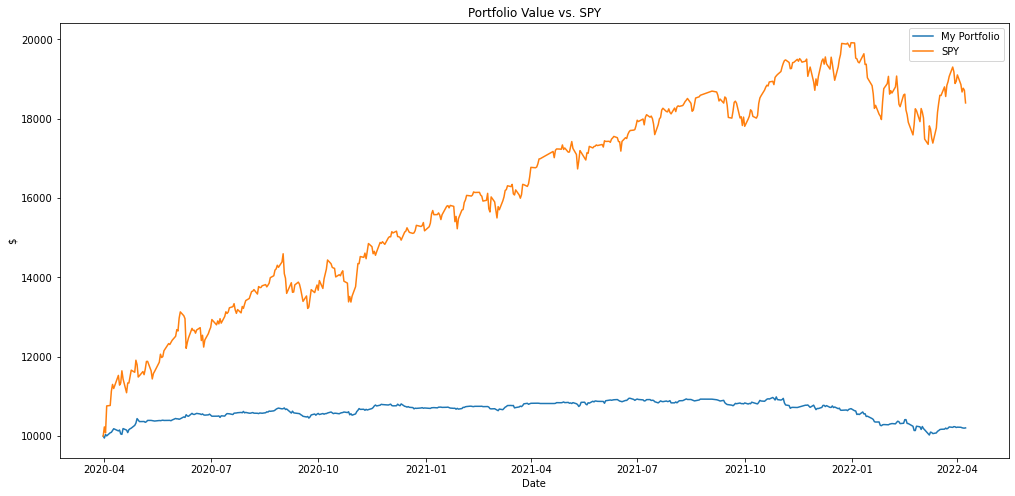

In [352]:
df_more = predictions[predictions['predicted'] == 1]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
display(all_holdings)

portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals)

spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

# Classifying Using Only Sentence Company Mentioned in Article 
### (sample size 200) light clean

In [375]:
df_sample = df_clean.sample(200)
date_split = '2020-01-30'
X_train8 = df_sample[df_sample['Date'] < date_split]['light_clean']
y_train8 = df_sample[df_sample['Date'] < date_split]['sentiment']
X_test8 = df_sample[df_sample['Date'] >= date_split]['light_clean']
y_test8 = df_sample[df_sample['Date'] >= date_split]['sentiment']
len(X_train8)

99

In [376]:
classifier2 = classification_model()
classifier2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier2.fit(X_train8, y_train8, epochs=2)

Epoch 1/2
4/4 [==============================] - 12s 1s/step - loss: 0.6109 - accuracy: 0.7172
Epoch 2/2
4/4 [==============================] - 6s 1s/step - loss: 0.6634 - accuracy: 0.6869


In [377]:
predictions = pd.DataFrame(classifier2.predict(X_test8), columns = ['Prediction'])
predictions.index = X_test8.index
predictions['actual'] = y_test8
predictions['predicted'] = predictions.apply(lambda row: 1 if row['Prediction'] >= .5 else 0, axis = 1)
predictions

,Prediction,actual,predicted
13270,0.878965,0,1
41241,0.816175,0,1
46122,0.823103,1,1
13075,0.813518,1,1
46749,0.778055,0,1
...,...,...,...
5901,0.678836,0,1
31245,0.763202,1,1
46087,0.747880,0,1
894,0.823234,0,1


In [379]:
predictions['Symbol'] = df_sample.loc[predictions.index]['Symbol']
predictions['currentPrice'] = df_sample.loc[predictions.index]['currentPrice']
predictions['actualPrice'] = df_sample.loc[predictions.index]['nextMonthPrice']
predictions['articleDate'] = df_sample.loc[predictions.index]['Date']
predictions['dateSold'] = df_sample.loc[predictions.index]['dateSold']
predictions

,Prediction,actual,predicted,Symbol,currentPrice,actualPrice,articleDate,dateSold
13270,0.878965,0,1,BA,304.140015,180.550003,2020-02-25,2020-03-26
41241,0.816175,0,1,MSFT,205.058899,208.555252,2020-08-10,2020-09-09
46122,0.823103,1,1,PFE,56.222534,53.860001,2022-01-03,2022-02-02
13075,0.813518,1,1,BA,194.490005,166.009995,2020-06-29,2020-07-29
46749,0.778055,0,1,PFE,36.589287,35.089806,2020-11-30,2020-12-30
...,...,...,...,...,...,...,...,...
5901,0.678836,0,1,AAPL,126.314705,132.548294,2021-05-26,2021-06-25
31245,0.763202,1,1,FAST,55.039463,59.910530,2021-10-14,2021-11-13
46087,0.747880,0,1,PFE,52.209999,55.169998,2022-03-15,2022-04-14
894,0.823234,0,1,AMZN,3091.860107,3379.090088,2021-03-16,2021-04-15


,Date,Close,Symbol,firstPrice,idx
144578,2020-02-25,304.140015,BA,304.140015,0
144579,2020-02-26,305.589996,BA,304.140015,0
144580,2020-02-27,287.760010,BA,304.140015,0
144581,2020-02-28,275.109985,BA,304.140015,0
144582,2020-03-02,289.269989,BA,304.140015,0
...,...,...,...,...,...
731526,2022-04-04,50.939999,PFE,52.209999,97
731527,2022-04-05,51.240002,PFE,52.209999,97
731528,2022-04-06,52.869999,PFE,52.209999,97
731529,2022-04-07,55.160000,PFE,52.209999,97


,Date,Total
0,2020-02-25,10000.000000
0,2020-02-26,10002.383740
0,2020-02-27,9973.071605
0,2020-02-28,9952.275222
0,2020-03-02,9975.553980
...,...,...
0,2022-04-04,10745.259332
0,2022-04-05,10739.255822
0,2022-04-06,10739.747938
0,2022-04-07,10833.107206


,Close,Date,Cumul. Return,SPY_Total
1225,300.832397,2020-02-26,1.000000,10000.000000
1226,287.321503,2020-02-27,0.955088,9550.882987
1227,286.114288,2020-02-28,0.951075,9510.753853
1228,298.504913,2020-03-02,0.992263,9922.631866
1229,289.957977,2020-03-03,0.963852,9638.522305
...,...,...,...,...
1757,451.029999,2022-04-05,1.499273,14992.733581
1758,446.519989,2022-04-06,1.484282,14842.815893
1759,448.769989,2022-04-07,1.491761,14917.608369
1760,447.570007,2022-04-08,1.487772,14877.719657


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

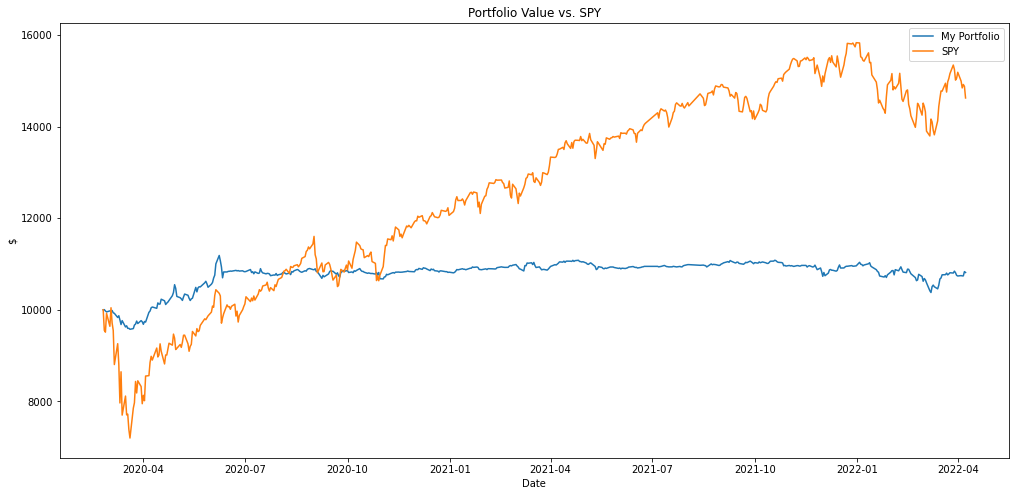

In [380]:
df_more = predictions[predictions['predicted'] == 1]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
display(all_holdings)

portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals)

spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

### 50 articles light clean (manually labeled)

In [616]:
date_split = '2020-01-30'
X_train11 = fifty_fifty[fifty_fifty['Date'] < date_split]['light_clean']
y_train11 = fifty_fifty[fifty_fifty['Date'] < date_split]['sentiment']
X_test11 = fifty_fifty[fifty_fifty['Date'] >= date_split]['light_clean']
y_test11 = fifty_fifty[fifty_fifty['Date'] >= date_split]['sentiment']
len(X_train11)

25

In [660]:
# check if price increases at all 
days = []
for i in range(len(fifty_fifty)):
    if fifty_fifty.iloc[i]['sentiment'] == 1:
        tmp = daily_prices[daily_prices['Symbol'] == fifty_fifty.iloc[i]['Symbol']]
        tmp = tmp[tmp['Date'] > str(fifty_fifty.iloc[i]['Date'])]
        tmp = tmp[tmp['Date'] <= str(fifty_fifty.iloc[i]['Date'] + pd.DateOffset(days = 30))]
        tmp = tmp[tmp['Close'] > fifty_fifty.iloc[i]['currentPrice']]
        if len(tmp) == 0:
            days.append(-1)
            continue
        tmp = tmp[tmp['Date'] == min(tmp['Date'])]
        tmp['Date'] = pd.to_datetime(tmp['Date'], format="%Y-%m-%d")
        d = int(str(tmp.iloc[0]['Date'] - fifty_fifty.iloc[i]['Date']).split()[0])
        days.append(d)

{-1: 3, 1: 12, 2: 2, 3: 2, 4: 1, 5: 2, 9: 1, 13: 1, 24: 1, 29: 1}

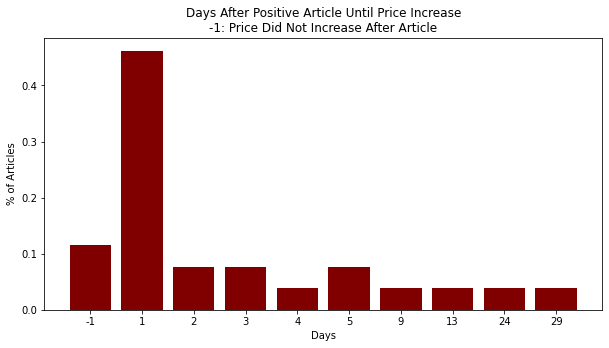

In [661]:
days_dict = collections.Counter(days)
d = {}
plt.figure(figsize = (10, 5))
keys = list(days_dict.keys())
keys.sort()
for k in keys:
    d[k] = days_dict[k]
plt.bar([str(x) for x in keys], np.array(list(d.values())) / len(fifty_fifty[fifty_fifty['sentiment'] == 1]), color ='maroon')  
plt.xlabel('Days')
plt.ylabel('% of Articles')
plt.title('Days After Positive Article Until Price Increase\n-1: Price Did Not Increase After Article')
d

In [665]:
# check if price increases by more than 3%
days = []
for i in range(len(fifty_fifty)):
    if fifty_fifty.iloc[i]['sentiment'] == 1:
        tmp = daily_prices[daily_prices['Symbol'] == fifty_fifty.iloc[i]['Symbol']]
        tmp = tmp[tmp['Date'] > str(fifty_fifty.iloc[i]['Date'])]
        tmp = tmp[tmp['Date'] <= str(fifty_fifty.iloc[i]['Date'] + pd.DateOffset(days = 30))]
        tmp = tmp[tmp['Close'] > fifty_fifty.iloc[i]['currentPrice'] * 1.03]
        if len(tmp) == 0:
            days.append(-1)
            continue
        tmp = tmp[tmp['Date'] == min(tmp['Date'])]
        tmp['Date'] = pd.to_datetime(tmp['Date'], format="%Y-%m-%d")
        d = int(str(tmp.iloc[0]['Date'] - fifty_fifty.iloc[i]['Date']).split()[0])
        days.append(d)

{-1: 12, 1: 1, 2: 3, 5: 2, 8: 1, 9: 1, 15: 2, 21: 2, 24: 1, 29: 1}

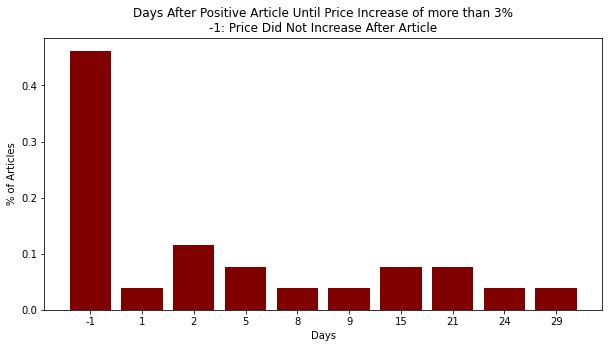

In [668]:
days_dict = collections.Counter(days)
d = {}
plt.figure(figsize = (10, 5))
keys = list(days_dict.keys())
keys.sort()
for k in keys:
    d[k] = days_dict[k]
plt.bar([str(x) for x in keys], np.array(list(d.values())) / len(fifty_fifty[fifty_fifty['sentiment'] == 1]), color ='maroon')  
plt.xlabel('Days')
plt.ylabel('% of Articles')
plt.title('Days After Positive Article Until Price Increase of more than 3%\n-1: Price Did Not Increase After Article')
d

In [684]:
# check when price reaches max price increase
days = []
for i in range(len(fifty_fifty)):
    if fifty_fifty.iloc[i]['sentiment'] == 1:
        tmp = daily_prices[daily_prices['Symbol'] == fifty_fifty.iloc[i]['Symbol']]
        tmp = tmp[tmp['Date'] > str(fifty_fifty.iloc[i]['Date'])]
        tmp = tmp[tmp['Date'] <= str(fifty_fifty.iloc[i]['Date'] + pd.DateOffset(days = 30))]
        tmp = tmp[tmp['Close'] > fifty_fifty.iloc[i]['currentPrice']]
        if len(tmp) == 0:
            days.append(-1)
            continue
        tmp = tmp[tmp['Close'] == max(tmp['Close'])]
        tmp['Date'] = pd.to_datetime(tmp['Date'], format="%Y-%m-%d")
        d = int(str(tmp.iloc[0]['Date'] - fifty_fifty.iloc[i]['Date']).split()[0])
        days.append(d)

{-1: 3,
 2: 2,
 3: 1,
 5: 1,
 8: 1,
 9: 1,
 11: 1,
 12: 2,
 13: 1,
 19: 1,
 20: 1,
 23: 1,
 24: 1,
 27: 1,
 28: 3,
 29: 1,
 30: 4}

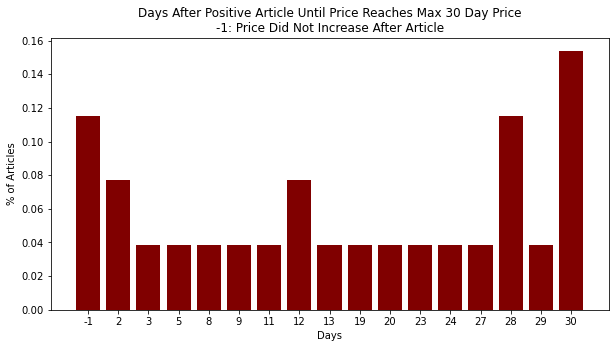

In [686]:
days_dict = collections.Counter(days)
d = {}
plt.figure(figsize = (10, 5))
keys = list(days_dict.keys())
keys.sort()
for k in keys:
    d[k] = days_dict[k]
plt.bar([str(x) for x in keys], np.array(list(d.values())) / len(fifty_fifty[fifty_fifty['sentiment'] == 1]), color ='maroon')  
plt.xlabel('Days')
plt.ylabel('% of Articles')
plt.title('Days After Positive Article Until Price Reaches Max 30 Day Price\n-1: Price Did Not Increase After Article')
d

In [670]:
# check if negative articles decrease in price
days = []
for i in range(len(fifty_fifty)):
    if fifty_fifty.iloc[i]['sentiment'] == 0:
        tmp = daily_prices[daily_prices['Symbol'] == fifty_fifty.iloc[i]['Symbol']]
        tmp = tmp[tmp['Date'] > str(fifty_fifty.iloc[i]['Date'])]
        tmp = tmp[tmp['Date'] <= str(fifty_fifty.iloc[i]['Date'] + pd.DateOffset(days = 30))]
        tmp = tmp[tmp['Close'] < fifty_fifty.iloc[i]['currentPrice']]
        if len(tmp) == 0:
            days.append(-1)
            continue
        tmp = tmp[tmp['Date'] == min(tmp['Date'])]
        tmp['Date'] = pd.to_datetime(tmp['Date'], format="%Y-%m-%d")
        d = int(str(tmp.iloc[0]['Date'] - fifty_fifty.iloc[i]['Date']).split()[0])
        days.append(d)

{-1: 4, 1: 8, 2: 2, 3: 6, 4: 2, 7: 1, 11: 1}

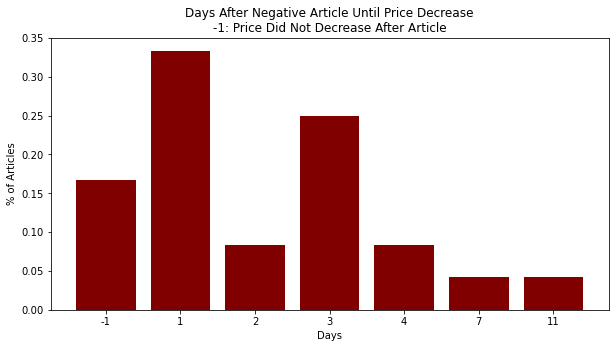

In [671]:
days_dict = collections.Counter(days)
d = {}
plt.figure(figsize = (10, 5))
keys = list(days_dict.keys())
keys.sort()
for k in keys:
    d[k] = days_dict[k]
plt.bar([str(x) for x in keys], np.array(list(d.values())) / len(fifty_fifty[fifty_fifty['sentiment'] == 0]), color ='maroon')  
plt.xlabel('Days')
plt.ylabel('% of Articles')
plt.title('Days After Negative Article Until Price Decrease\n-1: Price Did Not Decrease After Article')
d

In [619]:
date_split = '2020-01-30'
X_train9 = fifty_fifty[fifty_fifty['Date'] < date_split]['light_clean']
y_train9 = fifty_fifty[fifty_fifty['Date'] < date_split]['sentiment']
X_test9 = fifty_fifty[fifty_fifty['Date'] >= date_split]['light_clean']
y_test9 = fifty_fifty[fifty_fifty['Date'] >= date_split]['sentiment']
len(X_train9)

25

In [700]:
classifier3 = classification_model()
classifier3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier3.fit(X_train9, y_train9, epochs=2)

Epoch 1/2
1/1 [==============================] - 6s 6s/step - loss: 3.6396 - accuracy: 0.5600
Epoch 2/2
1/1 [==============================] - 1s 1s/step - loss: 7.3196 - accuracy: 0.5200


In [701]:
predictions = pd.DataFrame(classifier3.predict(X_test9), columns = ['Prediction'])
predictions.index = X_test9.index
predictions['actual'] = y_test9
predictions['predicted'] = predictions.apply(lambda row: 1 if row['Prediction'] >= .5 else 0, axis = 1)
predictions.head()

,Prediction,actual,predicted
13,6.376669,0,1
582,6.399794,0,1
640,6.441497,0,1
1138,6.415579,0,1
1511,6.252379,0,1


In [702]:
predictions['Symbol'] = fifty_fifty.loc[predictions.index]['Symbol']
predictions['currentPrice'] = fifty_fifty.loc[predictions.index]['currentPrice']
predictions['actualPrice'] = fifty_fifty.loc[predictions.index]['nextMonthPrice']
predictions['articleDate'] = fifty_fifty.loc[predictions.index]['Date']
predictions['dateSold'] = fifty_fifty.loc[predictions.index]['dateSold']
predictions.head()

,Prediction,actual,predicted,Symbol,currentPrice,actualPrice,articleDate,dateSold
13,6.376669,0,1,MO,43.927376,46.571022,2021-04-20,2021-05-20
582,6.399794,0,1,AMZN,3344.939941,3478.050049,2021-08-06,2021-09-05
640,6.441497,0,1,AMZN,3681.679932,3293.969971,2021-07-14,2021-08-13
1138,6.415579,0,1,AMZN,3036.149902,3195.340088,2020-10-30,2020-11-29
1511,6.252379,0,1,AMZN,2379.610107,2483.000000,2020-05-08,2020-06-07


In [703]:
len(predictions[predictions['actual'] == predictions['predicted']])

13

In [655]:
# check if stocks predicted as positive increase
days = []
for i in range(len(predictions)):
    if predictions.iloc[i]['predicted'] == 1:
        tmp = daily_prices[daily_prices['Symbol'] == predictions.iloc[i]['Symbol']]
        tmp = tmp[tmp['Date'] > str(predictions.iloc[i]['articleDate'])]
        tmp = tmp[tmp['Date'] <= str(predictions.iloc[i]['articleDate'] + pd.DateOffset(days = 30))]
        tmp = tmp[tmp['Close'] > predictions.iloc[i]['currentPrice']]
        if len(tmp) == 0:
            days.append(-1)
            continue
        tmp = tmp[tmp['Date'] == min(tmp['Date'])]
        tmp['Date'] = pd.to_datetime(tmp['Date'], format="%Y-%m-%d")
        d = int(str(tmp.iloc[0]['Date'] - predictions.iloc[i]['articleDate']).split()[0])
        days.append(d)

{-1: 2, 1: 6, 3: 1, 4: 4, 5: 1, 12: 1, 14: 1, 21: 1, 29: 1}

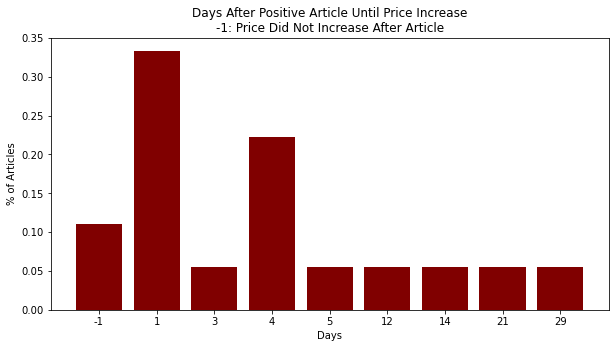

In [656]:
days_dict = collections.Counter(days)
d = {}
plt.figure(figsize = (10, 5))
keys = list(days_dict.keys())
keys.sort()
for k in keys:
    d[k] = days_dict[k]
plt.bar([str(x) for x in keys], np.array(list(d.values())) / len(predictions[predictions['predicted'] == 1]), color ='maroon')  
plt.xlabel('Days')
plt.ylabel('% of Articles')
plt.title('Days After Positive Article Until Price Increase\n-1: Price Did Not Increase After Article')
d

In [657]:
# check if stocks predicted as positive increases by more than 3%
days = []
for i in range(len(predictions)):
    if predictions.iloc[i]['predicted'] == 1:
        tmp = daily_prices[daily_prices['Symbol'] == predictions.iloc[i]['Symbol']]
        tmp = tmp[tmp['Date'] > str(predictions.iloc[i]['articleDate'])]
        tmp = tmp[tmp['Date'] <= str(predictions.iloc[i]['articleDate'] + pd.DateOffset(days = 30))]
        tmp = tmp[tmp['Close'] > predictions.iloc[i]['currentPrice'] * 1.03]
        if len(tmp) == 0:
            days.append(-1)
            continue
        tmp = tmp[tmp['Date'] == min(tmp['Date'])]
        tmp['Date'] = pd.to_datetime(tmp['Date'], format="%Y-%m-%d")
        d = int(str(tmp.iloc[0]['Date'] - predictions.iloc[i]['articleDate']).split()[0])
        days.append(d)

{-1: 6, 1: 1, 2: 3, 5: 3, 14: 2, 16: 1, 25: 1, 26: 1}

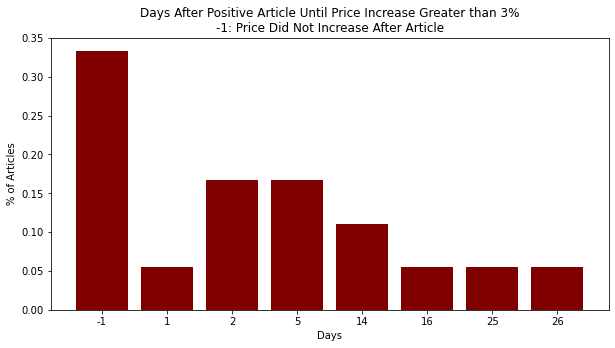

In [659]:
days_dict = collections.Counter(days)
d = {}
plt.figure(figsize = (10, 5))
keys = list(days_dict.keys())
keys.sort()
for k in keys:
    d[k] = days_dict[k]
plt.bar([str(x) for x in keys], np.array(list(d.values())) / len(predictions[predictions['predicted'] == 1]), color ='maroon')  
plt.xlabel('Days')
plt.ylabel('% of Articles')
plt.title('Days After Positive Article Until Price Increase Greater than 3%\n-1: Price Did Not Increase After Article')
d

In [653]:
# check if stocks predicted negative decrease in price
days = []
for i in range(len(predictions)):
    if predictions.iloc[i]['predicted'] == 0:
        tmp = daily_prices[daily_prices['Symbol'] == predictions.iloc[i]['Symbol']]
        tmp = tmp[tmp['Date'] > str(predictions.iloc[i]['articleDate'])]
        tmp = tmp[tmp['Date'] <= str(predictions.iloc[i]['articleDate'] + pd.DateOffset(days = 30))]
        tmp = tmp[tmp['Close'] < predictions.iloc[i]['currentPrice']]
        if len(tmp) == 0:
            days.append(-1)
            continue
        tmp = tmp[tmp['Date'] == min(tmp['Date'])]
        tmp['Date'] = pd.to_datetime(tmp['Date'], format="%Y-%m-%d")
        d = int(str(tmp.iloc[0]['Date'] - predictions.iloc[i]['articleDate']).split()[0])
        days.append(d)

{1: 2, 2: 1, 3: 1, 4: 1, 6: 1, 8: 1}

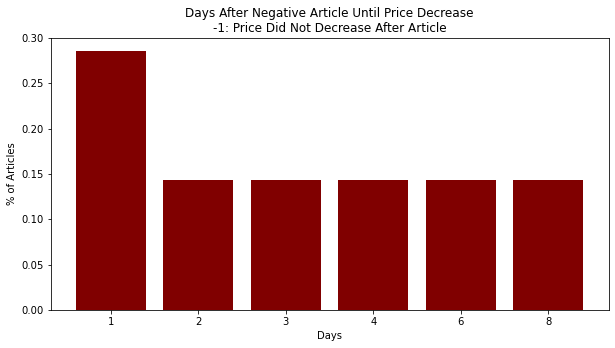

In [654]:
days_dict = collections.Counter(days)
d = {}
plt.figure(figsize = (10, 5))
keys = list(days_dict.keys())
keys.sort()
for k in keys:
    d[k] = days_dict[k]
plt.bar([str(x) for x in keys], np.array(list(d.values())) / len(predictions[predictions['predicted'] == 0]), color ='maroon')  
plt.xlabel('Days')
plt.ylabel('% of Articles')
plt.title('Days After Negative Article Until Price Decrease\n-1: Price Did Not Decrease After Article')
d

,Date,Close,Symbol,firstPrice,idx
90243,2020-05-19,77.432907,AAPL,77.432907,0
90244,2020-05-20,78.938828,AAPL,77.432907,0
144637,2020-05-19,130.440002,BA,130.440002,1
144638,2020-05-20,133.320007,BA,130.440002,1
51966,2020-06-29,2680.379883,AMZN,2680.379883,2
51967,2020-06-30,2758.820068,AMZN,2680.379883,2
60113,2020-10-26,11.800000,AAL,11.800000,3
60114,2020-10-27,11.230000,AAL,11.800000,3
52053,2020-10-30,3036.149902,AMZN,3036.149902,4
90358,2020-10-30,107.869240,AAPL,107.869240,5


,Date,Total
0,2020-05-19,10000.000000
0,2020-05-20,10020.763611
0,2020-06-29,10298.699927
0,2020-06-30,10313.332216
0,2020-10-26,10364.576810
0,2020-10-27,10340.424241
0,2020-10-30,10497.627630
0,2021-01-19,10560.271621
0,2021-03-24,10568.694654
0,2021-03-25,10580.628347


,Close,Date,Cumul. Return,SPY_Total
1284,288.447571,2020-05-20,1.000000,10000.000000
1285,286.456146,2020-05-21,0.993096,9930.960606
1312,300.869202,2020-06-30,1.043064,10430.637388
1313,302.976776,2020-07-01,1.050370,10503.703508
1395,331.324829,2020-10-27,1.148648,11486.483598
1396,320.000580,2020-10-28,1.109389,11093.890614
1399,323.468384,2020-11-02,1.121411,11214.113639
1452,377.666870,2021-01-20,1.309309,13093.085481
1497,384.638397,2021-03-25,1.333478,13334.776790
1498,390.836792,2021-03-26,1.354966,13549.664880


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

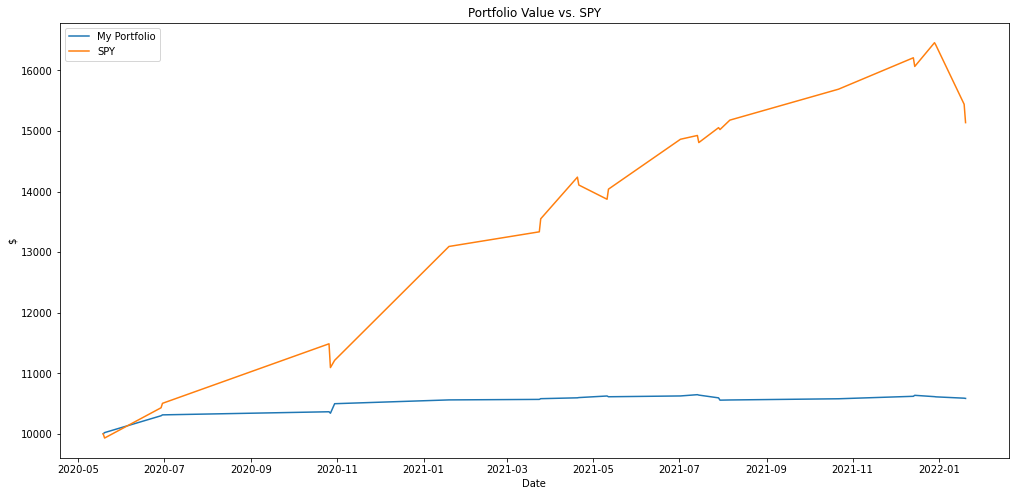

In [672]:
df_more = predictions[predictions['predicted'] == 1]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 2)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
display(all_holdings)

portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals)

spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

# Classifying Using Sentence Where Company Mentioned 
### 48,000 articles

In [336]:
classifier = classification_model()
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train7, y_train7, epochs=2)

Epoch 1/2
501/501 [==============================] - 1136s 2s/step - loss: 0.6140 - accuracy: 0.6917
Epoch 2/2
501/501 [==============================] - 1124s 2s/step - loss: 0.5993 - accuracy: 0.6966


In [340]:
predictions_classifier = pd.DataFrame(classifier.predict(X_test7), columns = ['Prediction'])
predictions_classifier.index = X_test7.index
predictions_classifier['actual'] = y_test7
predictions_classifier['predicted'] = predictions_classifier.apply(lambda row: 1 if row['Prediction'] >= .5 else 0, axis = 1)
predictions_classifier

,Prediction,actual,predicted
3,0.483740,1,0
4,0.595337,0,1
5,0.757583,1,1
6,0.660905,0,1
7,0.710872,1,1
...,...,...,...
62459,0.727517,1,1
62460,0.760613,1,1
62461,0.663490,1,1
62462,0.716831,1,1


In [342]:
predictions_classifier['Symbol'] = df_clean.loc[predictions_classifier.index]['Symbol']
predictions_classifier['currentPrice'] = df_clean.loc[predictions_classifier.index]['currentPrice']
predictions_classifier['actualPrice'] = df_clean.loc[predictions_classifier.index]['nextMonthPrice']
predictions_classifier['articleDate'] = df_clean.loc[predictions_classifier.index]['Date']
predictions_classifier['dateSold'] = df_clean.loc[predictions_classifier.index]['dateSold']
predictions_classifier

,Prediction,actual,predicted,Symbol,currentPrice,actualPrice,articleDate,dateSold
3,0.483740,1,0,MO,48.731728,53.619999,2022-02-24,2022-03-26
4,0.595337,0,1,MO,49.469044,50.815872,2022-02-15,2022-03-17
5,0.757583,1,1,MO,49.488705,50.609425,2022-01-27,2022-02-26
6,0.660905,0,1,MO,49.488705,50.609425,2022-01-27,2022-02-26
7,0.710872,1,1,MO,43.000420,42.190182,2021-10-28,2021-11-27
...,...,...,...,...,...,...,...,...
62459,0.727517,1,1,ZTS,197.935364,201.654922,2021-09-17,2021-10-17
62460,0.760613,1,1,ZTS,202.981216,199.830048,2021-09-14,2021-10-14
62461,0.663490,1,1,ZTS,201.315887,209.104050,2021-08-06,2021-09-05
62462,0.716831,1,1,ZTS,202.133591,203.250473,2021-07-30,2021-08-29


In [364]:
len(predictions_classifier[predictions_classifier['predicted'] == predictions_classifier['actual']])/ len(predictions_classifier)

0.7258961389840093

,Date,Close,Symbol,firstPrice,idx
374551,2018-12-31,56.147453,XOM,56.147453,0
374552,2019-01-02,57.382557,XOM,56.147453,0
374553,2019-01-03,56.501518,XOM,56.147453,0
374554,2019-01-04,58.584709,XOM,56.147453,0
374555,2019-01-07,58.889359,XOM,56.147453,0
...,...,...,...,...,...
133009,2022-03-28,96.730003,BBY,109.163940,1292
133010,2022-03-29,100.750000,BBY,109.163940,1292
133011,2022-03-30,96.430000,BBY,109.163940,1292
133012,2022-03-31,90.900002,BBY,109.163940,1292


,Date,Total
0,2018-12-31,10000.000000
0,2019-01-02,10116.433012
0,2019-01-03,9933.065521
0,2019-01-04,10349.331647
0,2019-01-07,10510.493364
...,...,...
0,2022-03-28,21087.862480
0,2022-03-29,21367.371739
0,2022-03-30,21273.053808
0,2022-03-31,21133.495856


,Close,Date,Cumul. Return,SPY_Total
936,237.122223,2019-01-02,1.000000,10000.000000
937,231.463821,2019-01-03,0.976137,9761.371945
938,239.216904,2019-01-04,1.008834,10088.337599
939,241.103043,2019-01-07,1.016788,10167.880499
940,243.368271,2019-01-08,1.026341,10263.410485
...,...,...,...,...
1752,461.549988,2022-03-29,1.946464,19464.644948
1753,458.700012,2022-03-30,1.934445,19344.454796
1754,451.640015,2022-03-31,1.904672,19046.718149
1755,452.920013,2022-04-01,1.910070,19100.698698


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

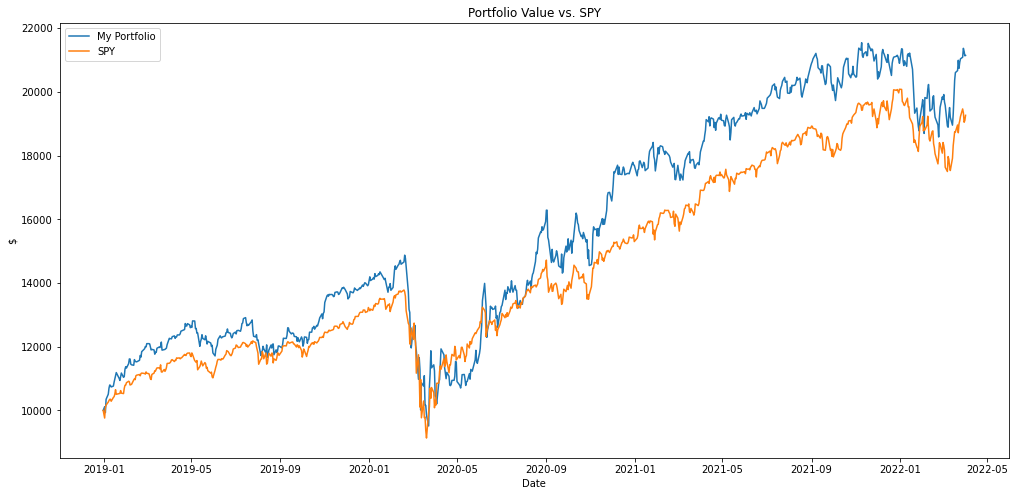

In [343]:
df_more = predictions_classifier[predictions_classifier['predicted'] == 1]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 30)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
display(all_holdings)

portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals)

spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

In [415]:
str(fifty_shortened.iloc[0]['Date']+ pd.DateOffset(days = 1) - fifty_shortened.iloc[0]['Date'])

'1 days 00:00:00'

### 50 articles shortened (manually labeled)

In [674]:
date_split = '2020-02-28'
X_train10 = fifty_fifty[fifty_fifty['Date'] < date_split]['shortened']
y_train10 = fifty_fifty[fifty_fifty['Date'] < date_split]['sentiment']
X_test10 = fifty_fifty[fifty_fifty['Date'] >= date_split]['shortened']
y_test10 = fifty_fifty[fifty_fifty['Date'] >= date_split]['sentiment']
len(X_train10)

25

In [675]:
classifier4 = classification_model()
classifier4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier4.fit(X_train10, y_train10, epochs=2)

Epoch 1/2
1/1 [==============================] - 8s 8s/step - loss: 0.6857 - accuracy: 0.4400
Epoch 2/2
1/1 [==============================] - 2s 2s/step - loss: 0.7091 - accuracy: 0.4800


In [676]:
predictions = pd.DataFrame(classifier4.predict(X_test10), columns = ['Prediction'])
predictions.index = X_test10.index
predictions['actual'] = y_test10
predictions['predicted'] = predictions.apply(lambda row: 1 if row['Prediction'] >= .5 else 0, axis = 1)
predictions.head()

,Prediction,actual,predicted
13,0.412802,0,0
582,0.486304,0,0
640,0.422739,0,0
1138,0.467762,0,0
1511,0.407694,0,0


In [677]:
predictions['Symbol'] = fifty_fifty.loc[predictions.index]['Symbol']
predictions['currentPrice'] = fifty_fifty.loc[predictions.index]['currentPrice']
predictions['actualPrice'] = fifty_fifty.loc[predictions.index]['nextMonthPrice']
predictions['articleDate'] = fifty_fifty.loc[predictions.index]['Date']
predictions['dateSold'] = fifty_fifty.loc[predictions.index]['dateSold']
predictions.head()

,Prediction,actual,predicted,Symbol,currentPrice,actualPrice,articleDate,dateSold
13,0.412802,0,0,MO,43.927376,46.571022,2021-04-20,2021-05-20
582,0.486304,0,0,AMZN,3344.939941,3478.050049,2021-08-06,2021-09-05
640,0.422739,0,0,AMZN,3681.679932,3293.969971,2021-07-14,2021-08-13
1138,0.467762,0,0,AMZN,3036.149902,3195.340088,2020-10-30,2020-11-29
1511,0.407694,0,0,AMZN,2379.610107,2483.000000,2020-05-08,2020-06-07


In [680]:
days = []
for i in range(len(predictions)):
    if predictions.iloc[i]['predicted'] == 1:
        tmp = daily_prices[daily_prices['Symbol'] == predictions.iloc[i]['Symbol']]
        tmp = tmp[tmp['Date'] > str(predictions.iloc[i]['articleDate'])]
        tmp = tmp[tmp['Date'] <= str(predictions.iloc[i]['articleDate'] + pd.DateOffset(days = 30))]
        tmp = tmp[tmp['Close'] > predictions.iloc[i]['currentPrice']]
        if len(tmp) == 0:
            days.append(-1)
            continue
        tmp = tmp[tmp['Date'] == min(tmp['Date'])]
        tmp['Date'] = pd.to_datetime(tmp['Date'], format="%Y-%m-%d")
        d = int(str(tmp.iloc[0]['Date'] - predictions.iloc[i]['articleDate']).split()[0])
        days.append(d)

{-1: 2, 1: 1, 29: 1}

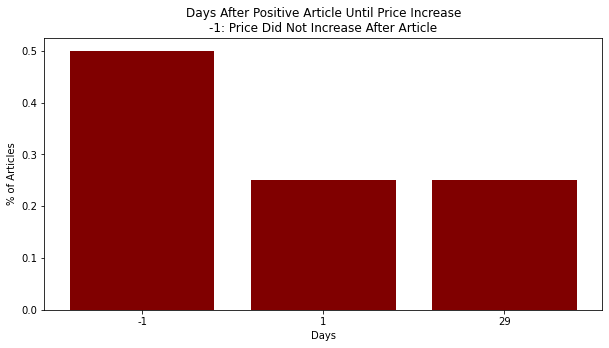

In [681]:
days_dict = collections.Counter(days)
d = {}
plt.figure(figsize = (10, 5))
keys = list(days_dict.keys())
keys.sort()
for k in keys:
    d[k] = days_dict[k]
plt.bar([str(x) for x in keys], np.array(list(d.values())) / len(predictions[predictions['predicted'] == 1]), color ='maroon')  
plt.xlabel('Days')
plt.ylabel('% of Articles')
plt.title('Days After Positive Article Until Price Increase\n-1: Price Did Not Increase After Article')
d

,Date,Close,Symbol,firstPrice,idx
224756,2021-01-19,61.319786,C,61.319786,0
52239,2021-07-29,3599.919922,AMZN,3599.919922,1
52240,2021-07-30,3327.590088,AMZN,3599.919922,1
60394,2021-12-07,17.889999,AAL,17.889999,2
60395,2021-12-08,18.230000,AAL,17.889999,2
108770,2022-01-19,254.350006,ADSK,254.350006,3
108771,2022-01-20,252.410004,ADSK,254.350006,3


,Date,Total
0,2021-01-19,10000.000000
0,2021-07-29,10008.423033
0,2021-07-30,9970.598604
0,2021-12-07,9973.659755
0,2021-12-08,9983.162274
0,2022-01-19,9992.664794
0,2022-01-20,9988.851147


,Close,Date,Cumul. Return,SPY_Total
1452,377.666870,2021-01-20,1.000000,10000.000000
1585,434.230377,2021-07-30,1.149771,11497.709001
1586,433.319336,2021-08-02,1.147359,11473.586121
1676,466.427216,2021-12-08,1.235023,12350.228534
1677,463.278137,2021-12-09,1.226685,12266.846098
1705,445.366425,2022-01-20,1.179257,11792.573291
1706,436.623596,2022-01-21,1.156108,11561.077519


Text(0.5, 1.0, 'Portfolio Value vs. SPY')

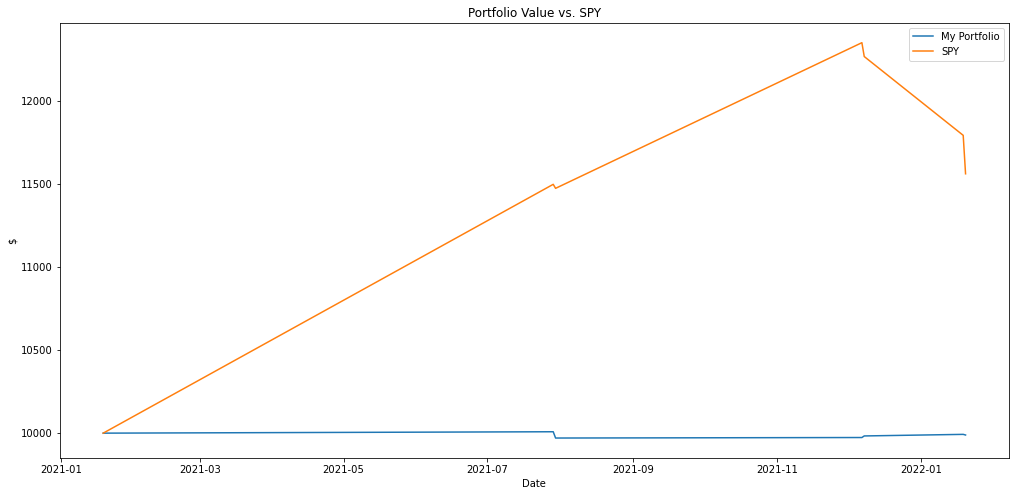

In [682]:
df_more = predictions[predictions['predicted'] == 1]
df_more['dateSold'] = df_more['articleDate'] + pd.DateOffset(days = 2)
buying_power = 10000
amount = 500
total = buying_power
dates = pd.date_range(start=df_more['articleDate'].min(),end=df_more['articleDate'].max()+ pd.DateOffset(days = 31))
invested = []
ds = []
t = []
current = pd.DataFrame({})
all_holdings = pd.DataFrame({})
y = 0
z = 0
for i in range(len(dates)):
#if str(df_more.iloc[j]['articleDate'])[:10] == str(dates[i])[:10]:
    print(dates[i])
    tmp = df_more[df_more['articleDate'] == str(dates[i])[:10]]
    if len(tmp) > 0:
        nBought = 0
        tmp = tmp[tmp['Symbol'] != 'VIAC']
        for j in range(len(tmp)):
            if buying_power >= 500:
                buying_power -= 500
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([amount])).to_frame().T
                current = current.append(test2)
                nBought += 1
            elif buying_power > 0:
                x = buying_power
                buying_power -= x
                test = tmp.iloc[j]
                test2 = test.append(pd.Series([x])).to_frame().T
                current = current.append(test2)
                nBought += 1
        curr2 = pd.DataFrame({})
        for j in range(y, len(current)):
            #test = yf.Ticker(current.iloc[j]['Symbol'])            
            d1 = str(current.iloc[j]['articleDate'])[:10]
            d2 = str(current.iloc[j]['dateSold'])[:10]
            #test2 = test.history(start=d1, end = d2)
            #test2 = test2.reset_index()
            #test2 = test2[['Date', 'Close']]
            test2 = daily_prices[daily_prices['Date'] >= d1]
            test2 = test2[test2['Date'] < d2]
            test2 = test2[test2['Symbol'] == current.iloc[j]['Symbol']]
            test2 = test2[['Date', 'Close', 'Symbol']]
            #test2['Symbol'] = current.iloc[j]['Symbol']
            test2['firstPrice'] = test2.iloc[0]['Close']
            test2['idx'] = z
            z += 1
            curr2 = curr2.append(test2)
        y += nBought
        all_holdings = all_holdings.append(curr2)
    if len(current) > 0:
        tmp2 = current[current['dateSold'] == str(dates[i])[:10]]
        if len(tmp2) > 0:
            tmp2['profit'] = (tmp2['actualPrice'] / tmp2['currentPrice']) * tmp2[0]
            buying_power += tmp2['profit'].sum()
    t.append(buying_power)
    clear_output(wait = True)
            
display(all_holdings)

portfolio_vals = pd.DataFrame({})
history = current.reset_index()
for i in range(len(dates)):
    tmp = all_holdings[all_holdings['Date'] == str(datetime.strptime(str(dates[i]), '%Y-%m-%d %H:%M:%S'))[0:10]]
    if len(tmp) > 0:
        amount = 0
        for j in range(len(tmp)):
            amount += (tmp.iloc[j]['Close'] / tmp.iloc[j]['firstPrice']) * history.loc[tmp.iloc[j]['idx']][0]
        portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i] + amount]}))
    #else:
    #    portfolio_vals = portfolio_vals.append(pd.DataFrame({'Date' : [dates[i]], 'Total' : [t[i]]}))
display(portfolio_vals)

spy = pd.read_csv("SPY_daily.csv")
spy_df = pd.DataFrame({})
for i in range(len(portfolio_vals)):
    tmp = spy[spy['Date'] >= str(portfolio_vals.iloc[i]['Date'])]
    if len(tmp) == 0:
        tmp = spy[spy['Date'] == max(spy['Date'])]
    tmp = tmp[tmp['Date'] == min(tmp['Date'])]
    spy_df = spy_df.append(tmp.iloc[0])
spy_df['Cumul. Return'] = spy_df['Close'] / float(spy_df.iloc[0]['Close'])
spy_df['SPY_Total'] = init_investment * spy_df['Cumul. Return']
display(spy_df)

plt.figure(figsize=(17, 8))
plt.plot(portfolio_vals['Date'], portfolio_vals['Total'], label = 'My Portfolio')
plt.plot(portfolio_vals['Date'], spy_df['SPY_Total'], label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')

In [ ]:
# debugging percentage of positive stories increase, what percentage decrease